# Derivatives Analytics - Objects Relationships

**Author**: [Gabriele Pompa](https://www.linkedin.com/in/gabrielepompa/): gabriele.pompa@unisi.com

# Table of contents

[Executive Summary](#executive-summary)

**TODO**

### **Resources**: 

- [_Python for Finance (2nd ed.)_](http://shop.oreilly.com/product/0636920117728.do): Chapter 6 Object-Oriented Programming.


- [Object-Oriented Programming in Python](https://python-textbok.readthedocs.io/en/1.0/index.html): Section [Object-oriented programming](https://python-textbok.readthedocs.io/en/1.0/Object_Oriented_Programming.html)


- [Polymorphism in Python](https://www.programiz.com/python-programming/polymorphism)

# Executive Summary <a name="executive-summary"></a>

**Make intro**

The following sections are organized as follows:

- **TODO**

These are the basic imports

In [1]:
# for NumPy arrays
import numpy as np

# for Pandas Series and DataFrame
import pandas as pd

# for statistical functions
from scipy import stats

# for Matplotlib plotting
import matplotlib.pyplot as plt

# to do inline plots in the Notebook
%matplotlib inline

# for Operating System operations
import os

# for some mathematical functions
import math

# for date management
import datetime as dt

# 1. Inheritance and Polymorphism <a name="inheritanche-poly"></a>

make intro

## 1.1. _Focus on:_ Digital Options <a name="inheritanche-poly"></a>

A digital cash-or-nothing (CON) call/put option of maturity $T$ and strike $K$ on an asset $S$ is a contract paying to the owner a certain amount of cash $Q$ should the asset settle above/below the strike at maturity. The payoff of a digital call option contract at time $T$ is then

$$
Q  \times \mathcal{I}_{\left\{S_T > K\right\}}
$$

and, symmetrically, for a put option

$$
Q  \times \mathcal{I}_{\left\{S_T \leq K\right\}}
$$

where $\mathcal{I}_{x}$ is the indicator function for event $x$, worth $1$ in case $x$ materializes and $0$ otherwise.

As before, we consider non-dividend paying underlying asset $S$. At any time $t \leq T$, the price $c_t$ of the digital CON call option under the Black-Scholes model is given by

$$
c^{CON}_t = Q e^{-r \tau} N(d_2)
$$

where $\tau = T-t$ is the option time-to-maturity, $r$ is the continuously compounding short-rate, $N(z)$ is the cumulative distribution function of a standard normal random variable and the $d_2$ argument has been already defined for plain-vanilla options. For theoretical background (an notation) we refer to [_Financial Modeling 1_ lecture notes](https://finmod1.wordpress.com/lecture-notes/) from Professor Pacati.

Independently from the valuation model used to price the option (we assume constant deterministic short-rate $r$ here and everywhere in this notebook), there are non-arbitrage arguments leading to upper and lower limits for the price of the CON options. At any time $t \leq T$, the price $\text{price}_t$ of both call and put CONs satisfies:

$$
0 \leq \text{price}_t \leq Q e^{-r \tau}
$$

This can be easily understood: since both type of CON options, at most, pay an amount of cash $Q$ in $T$, at any time $t \leq T$ they cannot be worth more than the discounted (from $T$ to $t$) amount of cash, that is $Q e^{-r (T-t)} = Q e^{-r \tau}$. Moreover, since the worst that can happen owning a CON option is that it expires worthless in $T$ (that is, not paying any cash), its current market value cannot be negative, then $0$ has to be the lower bound. 

Moreover, from the financial point of view, CON call and put prices are related by the following _parity_ relation

$$
c^{CON}_t + p^{CON}_t = Qe^{-r\tau}
$$

which we can use to compute the put price $p^{CON}_t$, once we know the call's price $c^{CON}_t$ and the other contract variables.

In the spirit of the `PlainVaillaOption` class developed before, we implement a Black-Scholes pricer for digital options as a `DigitalOption` class

For convenience, we report here `PlainVanillaOption` class

In [2]:
class PlainVanillaOption:
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    def __init__(self, option_type, S_t, K, t, T, r, sigma):

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = S_t
        self.__K     = K
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = r
        self.__sigma = sigma
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_type(self):
        return self.__type
    
    def get_S(self):
        return self.__S
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau
    
    def get_r(self):
        return self.__r

    def get_sigma(self):
        return self.__sigma
    
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label]    
    
    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
    def set_S(self, S):
        self.__S = S
        
    def set_K(self, K):
        self.__K = K
    
    def set_t(self, t):
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        # update time to maturity, given changed t, to keep internal consistency
        self.__update_tau() 

    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        # we could have updated valuation date as well, but this is a stylistic choice
        self.__update_T()

    def set_r(self, r):
        self.__r = r

    def set_sigma(self, sigma):
        self.__sigma = sigma
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.__time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity calculation
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return max(0.0, self.get_S() - self.get_K())
        # put case
        else:
            return max(0.0, self.get_K() - self.get_S())

    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_S()
        # put case
        else:
            return self.get_K()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return max(self.get_S() - self.get_K()*np.exp(-self.get_r() * self.get_tau()), 0)
        # put case
        else:
            return max(self.get_K()*np.exp(-self.get_r() * self.get_tau()) - self.get_S(), 0)
            
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price() + self.get_K() * np.exp(- self.get_r() * self.get_tau()) - self.get_S()        

The similarity with plain-vanilla options is apparent. The only difference is:

- the additional parameter `self.__Q` needed to initialize the digital option class with the cash amount $Q$;

- the functional form of the payoff, price boundaries and price.

In [3]:
class DigitalOption(object):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        Q (float):                cash amount
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a CON digital option price.

        price_lower_limit: float 
            Returns the lower limit for a CON digital option price
            .
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    def __init__(self, option_type, cash_amount, S_t, K, t, T, r, sigma):

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__Q     = cash_amount
        self.__S     = S_t
        self.__K     = K
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = r
        self.__sigma = sigma
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_type(self):
        return self.__type
    
    def get_Q(self):
        return self.__Q
    
    def get_S(self):
        return self.__S
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau
    
    def get_r(self):
        return self.__r

    def get_sigma(self):
        return self.__sigma
    
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label]    
    
    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
    
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
        
    def set_S(self, S):
        self.__S = S
        
    def set_K(self, K):
        self.__K = K
    
    def set_t(self, t):
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        # update time to maturity, given changed t, to keep internal consistency
        self.__update_tau() 

    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        # we could have updated valuation date as well, but this is a stylistic choice
        self.__update_T()

    def set_r(self, r):
        self.__r = r

    def set_sigma(self, sigma):
        self.__sigma = sigma
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.__time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity method (private)
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q() * int(self.get_S() > self.get_K())
        # put case
        else:
            return self.get_Q() * int(self.get_S() <= self.get_K())
        
    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())
        # put case
        else:
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return 0.0
        # put case
        else:
            return 0.0
        
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            Q     = self.get_Q()
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * self.get_tau()) - self.__call_price()        

Here is a `DigitalOption` object representing a digital CON call option

In [4]:
CON_Call = DigitalOption(option_type='call', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Call

DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [5]:
type(CON_Call)

__main__.DigitalOption

In [6]:
isinstance(CON_Call, DigitalOption)

True

In [7]:
CON_Call.price()

0.29674605684957245

and here another one representing a CON put option

In [8]:
CON_Put = DigitalOption(option_type='put', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Put

DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [9]:
type(CON_Put)

__main__.DigitalOption

In [10]:
isinstance(CON_Put, DigitalOption)

True

In [11]:
CON_Put.price()

0.6687932243156424

In [12]:
CON_Put.payoff()

1.0

## 1.2. Polymorphism <a name="poly"></a>

Polymorphism (from ancient Greek: $\pi \omicron \lambda \upsilon$ + $\mu \omicron \rho \phi \eta'$ = $multiple$ + $shape$) is the condition of occurrence of the same thing in different forms. For a good treatment of polymorhism in Python refer to [this blog post](https://www.programiz.com/python-programming/polymorphism). 

The fact that both `PlainVanillaOption` and `DigitalOption` classes provide methods with the same name (like `.payoff()`, `.price()` and getters and setters for the attributes they have in common), is an example of _polymorphism._ 

In general, as long as two - otherwise unrelated - classes `A` and `B` define a method `.method()` with the same name - but possibly implemented in completely different ways by `A` and `B` (as is differently implemented the Black-Scholes `.price()` of a plain-vanilla from the Black-Scholes `.price()` of a CON option) - we can use the method `.method()` elsewhere (e.g. in other functions outside the classes) disregarding whether we are calling that method on objects of class `A` or `B`. We then say that classes `A` and `B` are implementing _polymorphism_ through the (polymorphic) method `.method()`.

We can leverage the polymorphism of `PlainVanillaOption` and `DigitalOption` classes to use our plotting functions `plot_multi_tau(option,...)` and `plot_single_tau(option,...)` with an object `option` of any of the two classes. In other words, we can plot, without any additional specifications, both plain-vanilla and CON options somehow _agnostically._

In [13]:
def plot_multi_tau(option, S_list, tau_list):
    """
    plot_multi_tau(option, S_list, tau_list) plot Plain-Vanilla or Cash-Or-Nothing option prices for underlying and 
    maturities in 'S_list' and 'tau_list', respectively.

    Parameters:
        option (PlainVanillaOption; DigitalOption): instance of PlainVanillaOption or DigitalOption class;
        S_list (List):                              list of underlying values;
        tau_list (List):                            list of times to maturity (in years);
        
    Returns:
        None;

    """

    # color cycle setup: basically a cycle of different shades of blue as many time to maturity there are
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(tau_list)+1)))
    
    # setting legend labels
    # plain vanilla case:
    if isinstance(option, PlainVanillaOption):
        title_label = "Plain Vanilla"
    # digital case:
    else:
        title_label = "Cash-Or-Nothing ($Q={}$)".format(option.get_Q())

    # define the figure
    fig, ax = plt.subplots(figsize=(10,6))

    # auxiliary variables
    numS = len(S_list)
    numTau = len(tau_list)

    # plot a dot to highlight the strike position
    ax.plot(K, 0, 'k.', ms=15, label="Strike $K$")

    # plot the price for different underlying values, one line for each different time to maturity tau
    for i in np.arange(numTau)[::-1]: # loop over reversed range
        
        option.set_tau(tau_list[i])
        price = np.zeros(numS)
        
        for j in np.arange(numS):
            option.set_S(S_list[j]) # reset of underlying value
            price[j] = option.price()
        
        ax.plot(S_list, price, '-', lw=1.5, label=r"$\tau={}$".format(option.get_tau()))
    
    # plot the red payoff line for different underlying values
    payoff = np.zeros(numS)
    for i in np.arange(numS):
        option.set_S(S_list[i]) # reset of underlying value
        payoff[i] = option.payoff()
    
    ax.plot(S_list, payoff, 'r-',  lw=1.5, label=option.get_docstring('payoff'))
    
    # set axis labels 
    ax.set_xlabel('Underlying $S_t$', fontsize=12) 
    ax.set_ylabel('Black-Scholes Price', fontsize=12) 

    # set title
    ax.set_title(r"Price of a {} {} Option $(S_t, K={}, \tau=T-t, r={}\%, \sigma={}\%)$ Vs $S$ (at different $\tau$)".
                 format(title_label, option.get_type(), option.get_K(), option.get_r()*100, option.get_sigma()*100), fontsize=12) 

    # add the legend ('best' loc parameters places the legend in the best position automatically)
    ax.legend(loc='best', ncol=1)
        
    # add a gride to ease visualization
    plt.grid(True)

    # show the plot
    fig.tight_layout()
    plt.show()

So let's plot a `CON_Call` CON call option

In [14]:
CON_Call = DigitalOption(option_type='call', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Call

DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [15]:
K = 100.0

S_strip = np.linspace(80, 120, 100)
S_strip = np.append(S_strip, K)
S_strip = np.sort(S_strip)
S_strip

array([ 80.        ,  80.4040404 ,  80.80808081,  81.21212121,
        81.61616162,  82.02020202,  82.42424242,  82.82828283,
        83.23232323,  83.63636364,  84.04040404,  84.44444444,
        84.84848485,  85.25252525,  85.65656566,  86.06060606,
        86.46464646,  86.86868687,  87.27272727,  87.67676768,
        88.08080808,  88.48484848,  88.88888889,  89.29292929,
        89.6969697 ,  90.1010101 ,  90.50505051,  90.90909091,
        91.31313131,  91.71717172,  92.12121212,  92.52525253,
        92.92929293,  93.33333333,  93.73737374,  94.14141414,
        94.54545455,  94.94949495,  95.35353535,  95.75757576,
        96.16161616,  96.56565657,  96.96969697,  97.37373737,
        97.77777778,  98.18181818,  98.58585859,  98.98989899,
        99.39393939,  99.7979798 , 100.        , 100.2020202 ,
       100.60606061, 101.01010101, 101.41414141, 101.81818182,
       102.22222222, 102.62626263, 103.03030303, 103.43434343,
       103.83838384, 104.24242424, 104.64646465, 105.05

In [16]:
tau_strip = np.array([0.05, 0.1, 0.25, 0.5, 0.75, 1.0])
tau_strip

array([0.05, 0.1 , 0.25, 0.5 , 0.75, 1.  ])

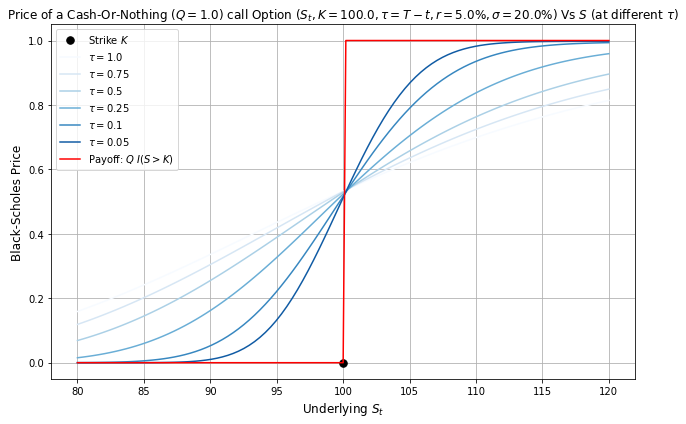

In [17]:
plot_multi_tau(CON_Call, S_strip, tau_strip)

and now a plain-vanilla put option

In [18]:
Vanilla_Put = PlainVanillaOption(option_type='put', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
Vanilla_Put

PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

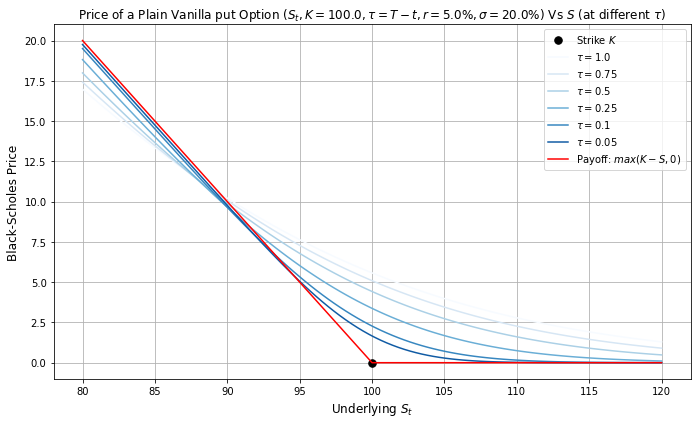

In [19]:
plot_multi_tau(Vanilla_Put, S_strip, tau_strip)

In [20]:
def plot_single_tau(option, S_list, tau):
    """
    plot_single_tau(option, S_list, tau) plot option prices for underlying in 'S_list' and time to maturity 'tau'.

    Parameters:
        option (PlainVanillaOption): instance of PlainVanillaOption class;
        S_list (List):               list of underlying values;
        tau (float):                 time to maturity (in years);
        
    Returns:
        None;

    """

    # define the figure
    fig, ax = plt.subplots(figsize=(10,6))
    
    # setting legend labels
    # plain vanilla case:
    if isinstance(option, PlainVanillaOption):
        title_label = "Plain Vanilla"
    # digital case:
    else:
        title_label = "Cash-Or-Nothing ($Q={}$)".format(option.get_Q())
            
    # auxiliary variable
    numS = len(S_list)

    # plot a dot to highlight the strike position
    ax.plot(option.get_K(), 0, 'k.', ms=15, label="Strike $K$")

    # plot the upper limit, the price and the lower limit for different underlying values
    upper_limit = np.zeros(numS)
    price       = np.zeros(numS)
    lower_limit = np.zeros(numS)
    payoff      = np.zeros(numS)

    for i in np.arange(numS):
        option.set_S(S_list[i]) # reset of underlying value
        
        upper_limit[i] = option.price_upper_limit()
        price[i]       = option.price()
        lower_limit[i] = option.price_lower_limit()
        payoff[i]      = option.payoff()

    ax.plot(S_list, upper_limit, 'k-.', lw=1.5, label=option.get_docstring('price_upper_limit'))
    ax.plot(S_list, price,       'b-',  lw=1.5, label=r"Price")
    ax.plot(S_list, lower_limit, 'k--', lw=1.5, label=option.get_docstring('price_lower_limit'))
    ax.plot(S_list, payoff,      'r-',  lw=1.5, label=option.get_docstring('payoff'))

    # set axis labels 
    ax.set_xlabel('Underlying $S_t$', fontsize=12) 
    ax.set_ylabel('Black-Scholes Price', fontsize=12) 

    # set title
    ax.set_title(r"Price of a {} {} Option $(S_t, K={}, \tau=T-t={:.1f}y, r={}\%, \sigma={}\%)$ Vs $S$ (with price limits)".
                 format(title_label, option.get_type(), option.get_K(), option.get_tau(), option.get_r()*100, 
                        option.get_sigma()*100), fontsize=12) 

    # add the legend ('best' loc parameters places the legend in the best position automatically)
    ax.legend(loc='best', ncol=1)

    # add a gride to ease visualization
    plt.grid(True)

    # show the plot
    fig.tight_layout()
    plt.show()

In [21]:
tau = 2.0

K_focus = 5

S_strip_focus = np.linspace(0, 10, 100)
S_strip_focus = np.append(S_strip_focus, K_focus)
S_strip_focus = np.sort(S_strip_focus)
S_strip_focus

array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.        ,  5.05050505,  5.15151515,  5.25252525,  5.35353535,
        5.45454545,  5.55555556,  5.65656566,  5.75757576,  5.85858586,
        5.95959596,  6.06060606,  6.16161616,  6.26262626,  6.36363636,
        6.46464646,  6.56565657,  6.66666667,  6.76767677,  6.86

In [22]:
CON_Call_focus = DigitalOption(option_type='call', 
                               cash_amount=1.0, 
                               S_t=3.0, 
                               K=5.0, 
                               t="19-04-2020", 
                               T="19-04-2022", 
                               r=0.05, 
                               sigma=0.2)

CON_Call_focus

DigitalOption('call', cash=1.0, S_t=3.0, K=5.0, t=19-04-2020, T=19-04-2022, tau=2.00y, r=5.0%, sigma=20.0%)

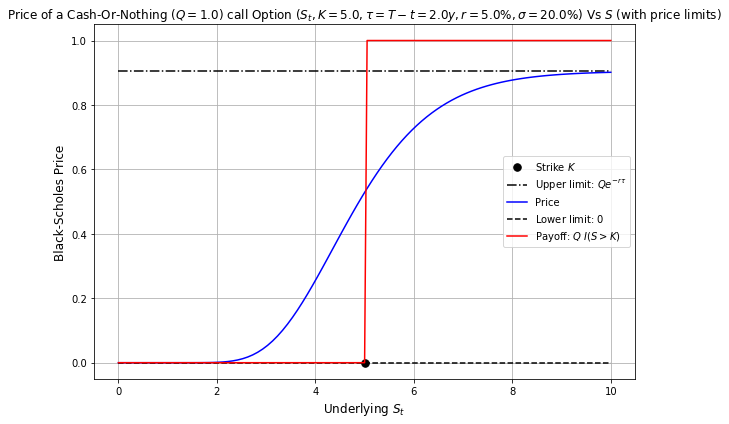

In [23]:
plot_single_tau(CON_Call_focus, S_strip_focus, CON_Call_focus.get_tau())

In [24]:
Vanilla_Put_focus = PlainVanillaOption(option_type='put', 
                                       S_t=3.0, 
                                       K=5.0, 
                                       t="19-04-2020", 
                                       T="19-04-2022", 
                                       r=0.05, 
                                       sigma=0.2)

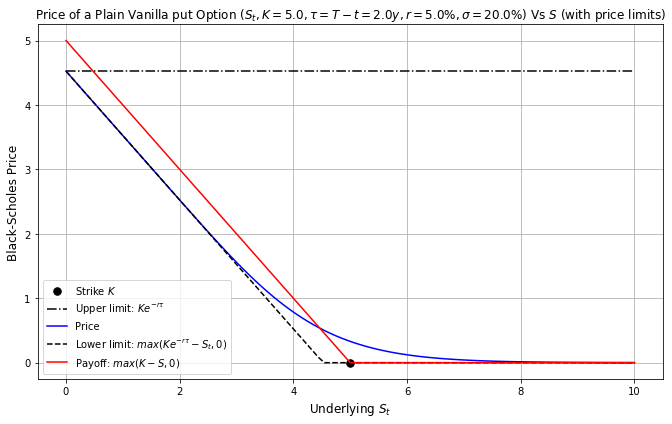

In [25]:
plot_single_tau(Vanilla_Put_focus, S_strip_focus, Vanilla_Put_focus.get_tau())

## 1.3. Inheritance <a name="inheritance"></a>

Given all the financial similarities between plain-vanilla and digital options, 

- don't you think that modeling `PlainVanillaOption` and `DigitalOption` as two completely unrelated classes is somehow at odds with their analogies? 

- And, looking at the body of the two classes, don't you think that there are a lot of repetitions?

_Inheritance_ is a way of arranging objects in a hierarchy from the most general to the most specific. It's a logical and programming paradygm modeling an _is a_ relationship between the most specific object and the most general one. At the end of the day, since both kind of options share european exercise (they cannot be exercised before expiration date $T$):

- a plain-vanilla option _is a_ european option,

- a digital option _is a_ european option.

We can translate this considerations defining a general `EuropeanOption` class and making `PlainVanillaOption` and `DigitalOption` _sub-classes_ of `EuropeanOption`. In this way, we are modeling the fact that:

- a `PlainVanillaOption` _is a_ `EuropeanOption`

- a `DigitalOption` _is a_ `EuropeanOption`.


We then refer to `EuropeanOption` class as the _parent_ (aka _mother_ or _base_ ) class and to any of `PlainVanillaOption` and `DigitalOption` as the _derived_ (aka _child_ or _sub-class_ ) class. 

The syntax is

```python
class BaseClass:
    ...
```
```python
class Child1(BaseClass):
    ...
```
```python
class Child2(BaseClass):
    ...
```
and you can have as many sub-classes as you want.

The idea is to put all the functionality that the classes have in common in a base class, and then define one or more subclasses with their own custom functionality.

Given a `.method()` implemented in the base class, sub-classes are then free to re-implement the same method (that is, keepig its name). We'll see an example with `.price()`: a method that is defined in `EuropeanOption` class and that both `PlainVaillaOption` and `DigitalOption` classes re-implement according to their specific needs. Methods defined in the base class and re-implemented by the derived classes are told _overriden_ methods. Therefore sub-classes implement polymorphism through the methods they override from the base class.

**TAKE-HOME MESSAGE**: key points are that

- all sub-classes derive attributes and methods defined in the base class. So that you define common attributes and methods once-for-all in the base class, and then you are able to access and use them from any of the sub-classes. 

- Whereas attributes and/or methods (if any) which are specific to one sub-class only, are defined within that sub-class only.

Here is our `EuropeanOption` base class implementation

In [26]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all common attributes
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """
    
    def __init__(self, option_type, S_t, K, t, T, r, sigma):
        
        print("Calling the EuropeanOption constructor!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = S_t
        self.__K     = K
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = r
        self.__sigma = sigma
        
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type
        
    def get_S(self):
        return self.__S
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau
    
    def get_r(self):
        return self.__r

    def get_sigma(self):
        return self.__sigma
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_S(self, S):
        self.__S = S
        
    def set_K(self, K):
        self.__K = K
    
    def set_t(self, t):
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        # update time to maturity, given changed t, to keep internal consistency
        self.__update_tau() 

    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        # we could have updated valuation date as well, but this is a stylistic choice
        self.__update_T()

    def set_r(self, r):
        self.__r = r

    def set_sigma(self, sigma):
        self.__sigma = sigma
        
    # update methods (private)
    def __update_tau(self):
        self.__tau = self.__time_to_maturity()

    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity method (private)
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()     

Notice that `EuropeanOption` defines all common attributes and methods. This avoid a lot of code repetition. Look for example at the time-to-maturity computation

```python
def __time_to_maturity(self):
    return (self.__T - self.__t).days / 365.0
```

since all european options derived from `EuropeanOption` should feature a time-to-maturity, it definitely makes sense to implement it here once-for-all and make it _inherited_ by all the sub-classes of `EuropeanOption`.

Notice also that most of the methods are left empty (eventually raising a `NotImplementedError()` to prevent from being called). This modeling choice has been taken because our `EuropeanOption` class is not meant to be instantiated. It is meant only to serves as a _template_ for all options with european-style exercise (that we derive from her). 

Consider for example the `.price()` method in `EuropeanOption`

```python
    # price template
    def price(self):
        raise NotImplementedError()     
```

Here we are making all classes derived from `EuropeanOption` _inheriting_ this method and we are imposing that each of them should override it providing an implementation for the method.

We say that `EuropeanOption` is an _abstract_ class.

Here are the derived classes: look how much code we are saving. Also, look how armhonically they integrate: we are leveraging on the financial similarities between the two kind of contracts, translating them in a considerable sharing of properties.

In [27]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Methods:
    --------   
    
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    # initializer with default arguments
    def __init__(self, option_type='call', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2):    
        # calling the EuropeanOption constructor
        super(PlainVanillaOption, self).__init__(option_type, S_t, K, t, T, r, sigma)
        
        # additional stuff - PlainVanillaOption-specific

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return max(0.0, self.get_S() - self.get_K())
        # put case
        else:
            return max(0.0, self.get_K() - self.get_S())

    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_S()
        # put case
        else:
            return self.get_K()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return max(self.get_S() - self.get_K()*np.exp(-self.get_r() * self.get_tau()), 0)
        # put case
        else:
            return max(self.get_K()*np.exp(-self.get_r() * self.get_tau()) - self.get_S(), 0)
            
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price() + self.get_K() * np.exp(- self.get_r() * self.get_tau()) - self.get_S()        

In [28]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        type (str):               type of the options. Can be either 'call' or 'put';
        Q (float):                cash amount
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        K (float):                strike price;
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                continuously compounded short-rate;
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getter and setter for cash amount attribute
        
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a CON digital option price.

        price_lower_limit: float 
            Returns the lower limit for a CON digital option price
            .
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    """
    
    # initializer with default arguments    
    def __init__(self, option_type='call', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2):
        # calling the EuropeanOption constructor
        super(DigitalOption, self).__init__(option_type, S_t, K, t, T, r, sigma)        

        # additional stuff - DigitalOption-specific
        self.__Q = cash_amount
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_Q(self):
        return self.__Q
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation
    def payoff(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q() * int(self.get_S() > self.get_K())
        # put case
        else:
            return self.get_Q() * int(self.get_S() <= self.get_K())
        
    # upper price limit
    def price_upper_limit(self):
        # call case
        if self.get_type() == 'call':
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())
        # put case
        else:
            return self.get_Q()*np.exp(-self.get_r() * self.get_tau())

    # lower price limit
    def price_lower_limit(self):
        # call case
        if self.get_type() == 'call':
            return 0.0
        # put case
        else:
            return 0.0
        
    # price calculation
    def price(self):
        # call case
        if self.get_type() == 'call':
            return self.__call_price()
        # put case
        else:
            return self.__put_price()
          
    def __call_price(self):
        
        # some local variables retrieved to be used repeatedly
        S = self.get_S()
        tau = self.get_tau()
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.payoff()
        else:
            Q     = self.get_Q()
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * self.get_tau()) - self.__call_price()        

**TODO** parlare del super()

In [29]:
Vanilla_Call = PlainVanillaOption()
Vanilla_Call

Calling the EuropeanOption constructor!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [30]:
type(Vanilla_Call)

__main__.PlainVanillaOption

In [31]:
isinstance(Vanilla_Call, PlainVanillaOption)

True

In [32]:
Vanilla_Call.get_K()

100.0

In [33]:
Vanilla_Call.price()

3.487402470943657

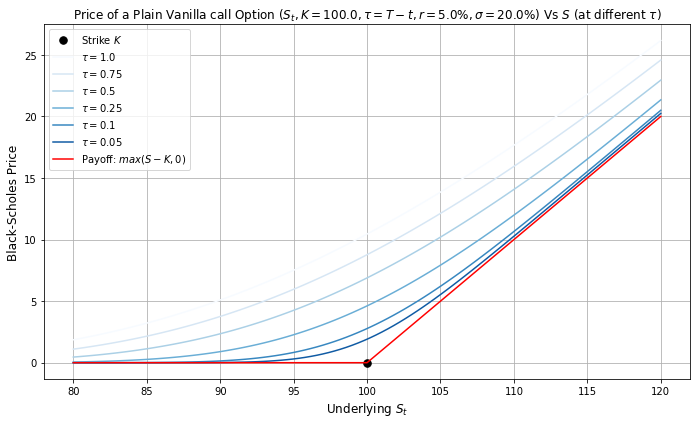

In [34]:
plot_multi_tau(Vanilla_Call, S_strip, tau_strip)

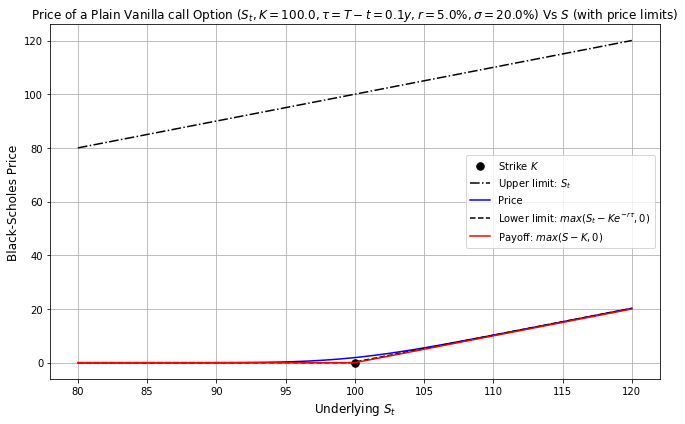

In [35]:
plot_single_tau(Vanilla_Call, S_strip, Vanilla_Call.get_tau())

In [36]:
Vanilla_Put = PlainVanillaOption(option_type='put', S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
Vanilla_Put

Calling the EuropeanOption constructor!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

which is equivalent to

In [37]:
Vanilla_Put = PlainVanillaOption(option_type='put')
Vanilla_Put

Calling the EuropeanOption constructor!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [38]:
type(Vanilla_Put)

__main__.PlainVanillaOption

In [39]:
isinstance(Vanilla_Put, PlainVanillaOption)

True

In [40]:
Vanilla_Put.get_K()

100.0

In [41]:
Vanilla_Put.price()

10.041330587465126

In [42]:
Vanilla_Put.payoff()

10.0

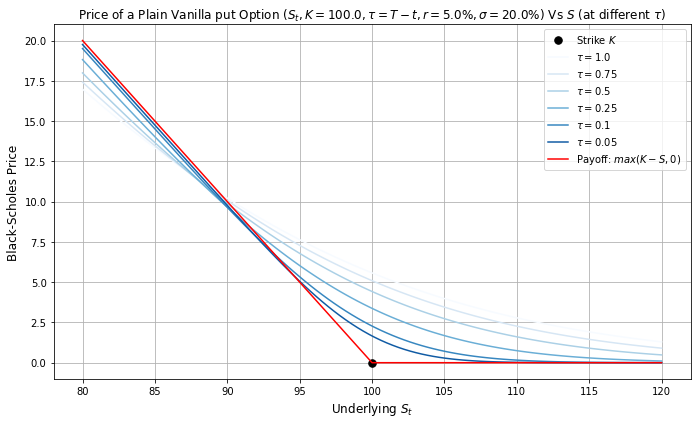

In [43]:
plot_multi_tau(Vanilla_Put, S_strip, tau_strip)

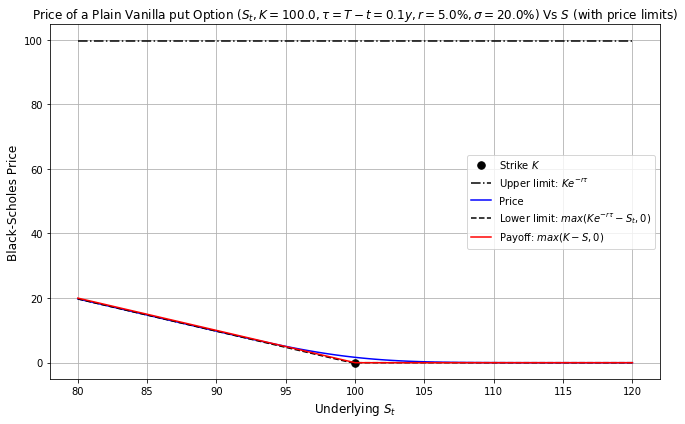

In [44]:
plot_single_tau(Vanilla_Put, S_strip, Vanilla_Put.get_tau())

let's now instantiate a digital option

In [45]:
CON_Call = DigitalOption()
CON_Call

Calling the EuropeanOption constructor!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [46]:
type(CON_Call)

__main__.DigitalOption

In [47]:
isinstance(CON_Call, DigitalOption)

True

In [48]:
CON_Call.get_K()

100.0

In [49]:
CON_Call.get_Q()

1.0

In [50]:
CON_Call.price()

0.29674605684957245

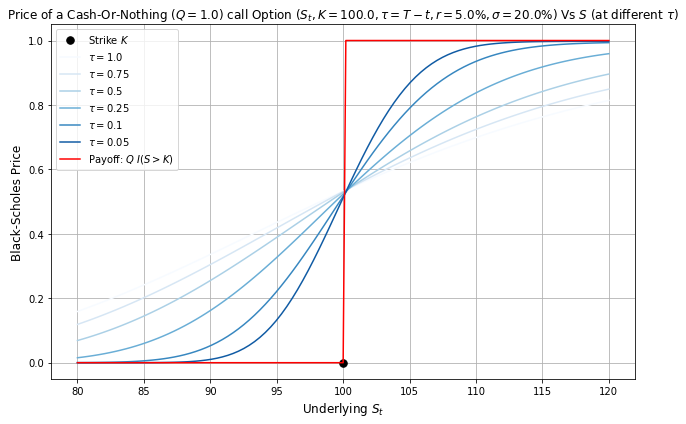

In [51]:
plot_multi_tau(CON_Call, S_strip, tau_strip)

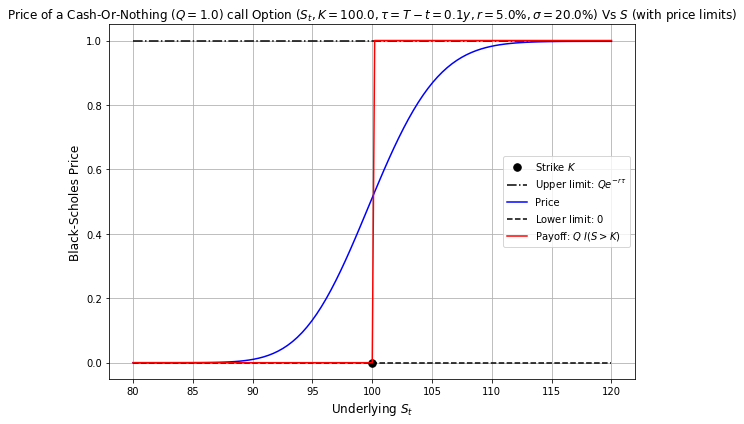

In [52]:
plot_single_tau(CON_Call, S_strip, CON_Call.get_tau())

In [53]:
CON_Put = DigitalOption(option_type='put', cash_amount = 1.0, S_t=90.0, K=100.0, t="19-04-2020", T="31-12-2020", r=0.05, sigma=0.2)
CON_Put

Calling the EuropeanOption constructor!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

equivalent to

In [54]:
CON_Put = DigitalOption(option_type='put')
CON_Put

Calling the EuropeanOption constructor!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [55]:
type(CON_Put)

__main__.DigitalOption

In [56]:
isinstance(CON_Put, DigitalOption)

True

In [57]:
CON_Put.get_K()

100.0

In [58]:
CON_Put.get_Q()

1.0

In [59]:
CON_Put.price()

0.6687932243156424

In [60]:
CON_Put.payoff()

1.0

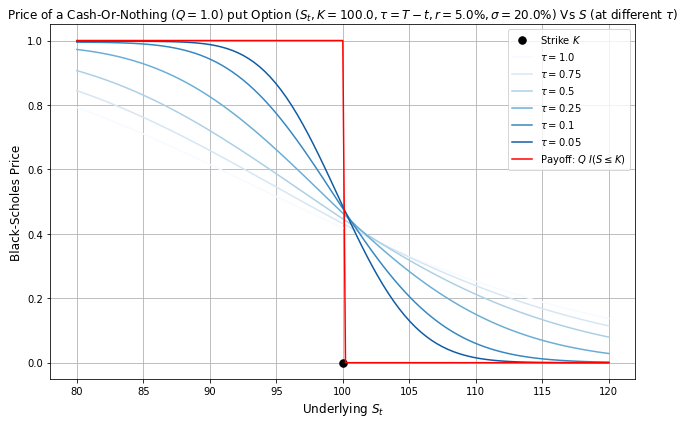

In [61]:
plot_multi_tau(CON_Put, S_strip, tau_strip)

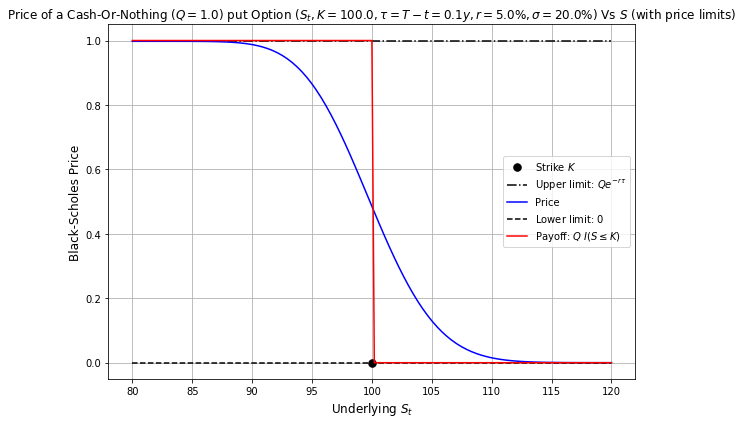

In [62]:
plot_single_tau(CON_Put, S_strip, CON_Put.get_tau())

## `*args` and `**kwargs`

In [63]:
def print_args(*args):
    for arg in args:
        print(arg)

In [64]:
print_args("one", "two", "three")

one
two
three


In [65]:
print_args("one", "two", "three", "four")

one
two
three
four


If a function takes `*args` positional parameters, it also means that we can call it unpacking (through the `*` operator) a standard Tuple, like `tup` here

In [66]:
tup = ("a", 1, "c")

print_args(*tup)

a
1
c


This make it easier to make variable-length positional parameters flow through nested functions, like here:

In [67]:
def print_args_wrapper(*args):
    print("I am in print_args_wrapper function")
    # here args is a Tuple, that is un-packed by the * operator and passed to print_args function
    print_args(*args)

In [68]:
print_args_wrapper(tup)

I am in print_args_wrapper function
('a', 1, 'c')


In [69]:
def print_kwargs(**kwargs):
    for k, v in kwargs.items():
        print("{}: {}".format(k, v))

In [70]:
print_kwargs(name="Jane", surname="Doe")

name: Jane
surname: Doe


In [71]:
print_kwargs(age=10)

age: 10


If a function takes `**args` keyword parameters, it also means that we can call it unpacking (through the `**` operator) a standard Dict, like `d` here

In [72]:
d = {"k1": "a", "k2": 1, "k3": "c"}

print_kwargs(**d)

k1: a
k2: 1
k3: c


This make it easier to make keyword parameters flow through nested functions, like here:

In [73]:
def print_kwargs_wrapper(**kwargs):
    print("I am in print_kwargs_wrapper function")
    # here kwargs is a Dict, that is un-packed in key-value pairs by the ** operator and passed to print_kwargs function
    print_kwargs(**kwargs)

In [74]:
print_kwargs_wrapper(**d)

I am in print_kwargs_wrapper function
k1: a
k2: 1
k3: c


If a function takes only `*args` and `**kwargs` as its parameters, it can be called with any set of parameters

In [75]:
def print_everything(*args, **kwargs):
    for arg in args:
        print(arg)

    for k, v in kwargs.items():
        print("{}: {}".format(k, v))

In [76]:
print_everything("one", "two", "three")

one
two
three


In [77]:
print_everything(name="Jane", surname="Doe")

name: Jane
surname: Doe


In [78]:
print_everything("one", "two", "three", name="Jane", surname="Doe")

one
two
three
name: Jane
surname: Doe


This means also no parameters

In [79]:
print_everything()

As previously seen for `*args` and `**kwargs` separately, the use of `*args` and `**kwargs` make it easy to flow parameters through nested functions, like here:

In [80]:
def print_everything_wrapper(*args, **kwargs):
    print("I am in print_everything_wrapper function")
    # here args is a Tuple, that is un-packed by the * operator and passed to print_everything function
    # here kwargs is a Dict, that is un-packed in key-value pairs by the ** operator and passed to print_everything function
    print_everything(*args, **kwargs)

In [81]:
print_everything_wrapper(*tup, **d)

I am in print_everything_wrapper function
a
1
c
k1: a
k2: 1
k3: c


DA RISPIEGARE 

This makes it allows the nesting function `print_everything_wrapper` to ignore the details of the parameters of the nested function `print_everything`. This is particularly useful when the nesting function is the constructor (the `__init__()`) of a derived class and the nested function is the constructor of the base class (the `super().__init__()`).

`*args` and `**kwargs` can be mixed with ordinary parameters, which must come first in function's definition

In [82]:
def print_everything_combined(city, title="default_title", *args, **kwargs):
    
    print("city is {}".format(city))
    
    print("title is {}".format(title))
    
    for arg in args:
        print(arg)

    for k, v in kwargs.items():
        print("{}: {}".format(k, v))

In [83]:
print_everything_combined("Rome", "one", "two", "three", name="Jane", surname="Doe")

city is Rome
title is one
two
three
name: Jane
surname: Doe


In [84]:
print_everything_combined("Rome", "different title", "one", "two", "three", name="Jane", surname="Doe")

city is Rome
title is different title
one
two
three
name: Jane
surname: Doe


In [85]:
# raises: SyntaxError: positional argument follows keyword argument
#
# print_everything_combined(city="Rome", "one", "two", "three", name="Jane", surname="Doe")

# Polymorphism application: a `Plotter()` class

First let's define a common MarketEnvironment class which shall contain the information on market environment and underlying level. This class will be used to instantiate the EuropeanOption class

In [86]:
class MarketEnvironment:
    """
    MarketEnvironment class: setting the market environment: date, underlying level, volatility level and short-rate.
    
    Attributes:
    -----------
        t (str; dt.datetime):     valuation date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        r (float):                continuously compounded short-rate;
        S_t (float):              spot price of the underlying asset at the valuation date 't';
        sigma (float):            volatility of underlying asset;
    
    Public Methods:
    --------   
    
        getters and setters for all attributes
        
    Usage: 
    --------   
        - default: MarketEnvironment() is equivalent to 
                   MarketEnvironment(t="19-04-2020", r=0.05, S_t=90.0, sigma=0.2)

        - general: MarketEnvironment(t="DD-MM-YYYY" String, r=Float, S_t=Float, sigma=Float)
    """
    
    def __init__(self, t="19-04-2020", r=0.05, S_t=90.0, sigma=0.2):
        
        print("Initializing the MarketEnvironment!")
        
        self.__t     = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t
        self.__r     = r
        self.__S     = S_t
        self.__sigma = sigma
        
    def __repr__(self):
        return r"MarketEnvironment(t={}, r={:.1f}%, S_t={:.1f}, sigma={:.1f}%)".\
               format(self.get_t().strftime("%d-%m-%Y"), self.get_r()*100, self.get_S(), self.get_sigma()*100)

    # getters
    def get_t(self):
        return self.__t

    def get_r(self):
        return self.__r

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    # setters 
    def set_t(self, t):
        # notice that there is no need to update the time-to-maturity of the options,
        # since in this way of modeling, the MarketEnvironment is the first thing that gets instantiated.
        # Financial instruments follow.
        self.__t = dt.datetime.strptime(t, "%d-%m-%Y") if isinstance(t, str) else t

    def set_r(self, r):
        self.__r = r

    def set_S(self, S):
        self.__S = S
        
    def set_sigma(self, sigma):
        self.__sigma = sigma

In [87]:
market_env = MarketEnvironment(t="01-06-2020", r=-0.002, S_t=10.0, sigma=0.4)
market_env

Initializing the MarketEnvironment!


MarketEnvironment(t=01-06-2020, r=-0.2%, S_t=10.0, sigma=40.0%)

In [88]:
market_env = MarketEnvironment()
market_env

Initializing the MarketEnvironment!


MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

In [89]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        type (str):               type of the option. Can be either 'call' or 'put';
        S_t (float):              'S' attribute of mkt_env.
        K (float):                strike price;
        t (str; dt.datetime):     't' attribute of mkt_env.
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                'r' attribute of mkt_env.
        sigma (float):            'sigma' attribute of mkt_env.
    
    Template Methods:
    --------   
    
        getters for all common attributes
        
        setters for common attributes, not belonging to mkt_env
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """

    def __init__(self, mkt_env, option_type='call', K=100.0, T="31-12-2020"):
        
        print("Initializing the EuropeanOption!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = mkt_env.get_S()
        self.__K     = K
        self.__t     = mkt_env.get_t()
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = mkt_env.get_r()
        self.__sigma = mkt_env.get_sigma()
               
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau

    def get_r(self):
        return self.__r
    
    def get_sigma(self):
        return self.__sigma
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_K(self, K):
        self.__K = K
    
    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        self.__update_T()
        
    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity method (private)
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()

In [90]:
from collections.abc import Iterable

In [91]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
    
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: PlainVanillaOption(mkt_env) is equivalent to 
                   PlainVanillaOption(mkt_env, option_type='call', K=100.0, T="31-12-2020")

        - general: PlainVanillaOption(mkt_env, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """
    
    # initializer with optional *args and **kwargs parameters
    def __init__(self, *args, **kwargs):  
        
        # calling the EuropeanOption constructor
        super(PlainVanillaOption, self).__init__(*args, **kwargs)
        
        # info strings
        self.__info = r"Plain Vanilla {} (K={:.1f}, tau={:.2f}y)".format(self.get_type(), self.get_K(), self.get_tau())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100)
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info

    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called as:
            - payoff(): uses .get_S() 
            - payoff(100.0): S == 100.0
            - payoff(S=100.0)
            - payoff([100.0, ..., 120.0]): S == [100.0, ..., 120.0] 
            - payoff(S=[100.0, ..., 120.0])
        """
        
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
                
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)
    
    def __call_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([max(0.0, s - self.get_K()) for s in S])
        else:
            return max(0.0, S - self.get_K())

    def __put_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([max(0.0, self.get_K() - s) for s in S])
        else:
            return max(0.0, self.get_K() - S)
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_upper_limit(): uses .get_S() and .get_tau()
            - price_upper_limit(100.0): S == 100.0
            - price_upper_limit(100.0, 0.1): S == 100.0 and tau == 0.1
            - price_upper_limit(S=100.0, tau=0.1)
            - price_upper_limit([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price_upper_limit(S=[100.0, ..., 120.0], tau=0.1)
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
                        
        # call case
        if self.get_type() == 'call':
            return S
        # put case
        else:
            return self.__put_price_upper_limit(S, tau)
    
    def __put_price_upper_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.repeat(self.get_K()*np.exp(-self.get_r() * tau), repeats=len(S)) 
        else:
            return self.get_K()*np.exp(-self.get_r() * tau)

    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_lower_limit(): uses .get_S() and .get_tau()
            - price_lower_limit(100.0): S == 100.0
            - price_lower_limit(100.0, 0.1): S == 100.0 and tau == 0.1
            - price_lower_limit(S=100.0, tau=0.1)
            - price_lower_limit([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price_lower_limit(S=[100.0, ..., 120.0], tau=0.1)
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
                                       
        # call case
        if self.get_type() == 'call':
            return self.__call_price_lower_limit(S, tau)
        # put case
        else:
            return self.__put_price_lower_limit(S, tau)

    def __call_price_lower_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.array([max(s - self.get_K()*np.exp(-self.get_r() * tau), 0.0) for s in S])
        else:
            return max(S - self.get_K()*np.exp(-self.get_r() * tau), 0.0)
                                       
    def __put_price_lower_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.array([max(self.get_K()*np.exp(-self.get_r() * tau) - s, 0.0) for s in S])
        else:
            return max(self.get_K()*np.exp(-self.get_r() * tau) - S, 0.0)
                                       
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called as:
            - price(): uses .get_S() and .get_tau()
            - price(100.0): S == 100.0
            - price(100.0, 0.1): S == 100.0 and tau == 0.1
            - price(S=100.0, tau=0.1)
            - price([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price(S=[100.0, ..., 120.0], tau=0.1)
        """
                       
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
               
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price(S, tau) + self.get_K() * np.exp(- self.get_r() * tau) - S     

In [92]:
Vanilla_Call = PlainVanillaOption(market_env, option_type='call', K=110.0, T="31-12-2022")
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2022, tau=2.70y, r=5.0%, sigma=20.0%)

In [93]:
Vanilla_Call = PlainVanillaOption(market_env)
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [94]:
Vanilla_Call.payoff() # using .get_S() 

0.0

In [95]:
Vanilla_Call.payoff(90) # using args[0] for S

0.0

In [96]:
Vanilla_Call.payoff(S=90) # using kwargs['S'] for S

0.0

In [97]:
Vanilla_Call.payoff([90, 100.0]) # using args[0] for S (and list in input)

array([0., 0.])

In [98]:
Vanilla_Call.payoff(S=[90, 100.0]) # using kwargs['S'] for S (and list in input) 

array([0., 0.])

In [99]:
Vanilla_Call.price() # using .get_S() and .get_tau()

3.487402470943657

In [100]:
Vanilla_Call.price(90) # using args[0] for S

3.487402470943657

In [101]:
Vanilla_Call.price(90, 0.1) # using args[0] for S and args[1] for tau

0.1434251971537872

In [102]:
Vanilla_Call.price(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.1434251971537872

In [103]:
Vanilla_Call.price([90, 100.0], tau=0.1) # using args[0] for S (and list in input) and args[1] for tau

array([0.1434252 , 2.77365415])

In [104]:
Vanilla_Call.price(S=[90, 100.0], tau=0.1) # using kwargs['S'] for S (and list in input) and kwargs['tau'] for tau

array([0.1434252 , 2.77365415])

In [105]:
Vanilla_Call.price_upper_limit() # using .get_S() and .get_tau()

90.0

In [106]:
Vanilla_Call.price_upper_limit(90) # using args[0] for S

90

In [107]:
Vanilla_Call.price_upper_limit(90, 0.1) # using args[0] for S and args[1] for tau

90

In [108]:
Vanilla_Call.price_upper_limit(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

90

In [109]:
Vanilla_Call.price_upper_limit([90, 100.0], tau=0.1) # using args[0] for S (and list in input) and args[1] for tau

[90, 100.0]

In [110]:
Vanilla_Call.price_upper_limit(S=[90, 100.0], tau=0.1) # using kwargs['S'] for S (and list in input) and kwargs['tau'] for tau

[90, 100.0]

In [111]:
Vanilla_Call.price_lower_limit() # using .get_S() and .get_tau()

0.0

In [112]:
Vanilla_Call.price_lower_limit(90) # using args[0] for S

0.0

In [113]:
Vanilla_Call.price_lower_limit(90, 0.1) # using args[0] for S and args[1] for tau

0.0

In [114]:
Vanilla_Call.price_lower_limit(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.0

In [115]:
Vanilla_Call.price_lower_limit([90, 100.0], tau=0.1) # using args[0] for S (and list in input) and args[1] for tau

array([0.        , 0.49875208])

In [116]:
Vanilla_Call.price_lower_limit(S=[90, 100.0], tau=0.1) # using kwargs['S'] for S (and list in input) and kwargs['tau'] for tau

array([0.        , 0.49875208])

the same can be done in the put case

In [117]:
Vanilla_Put = PlainVanillaOption(market_env, option_type='put')
Vanilla_Put

Initializing the EuropeanOption!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [118]:
Vanilla_Put.payoff() # using .get_S() 

10.0

etc

In [119]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        Q (float):                   cash amount
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
    
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: DigitalOption(mkt_env) is equivalent to 
                   DigitalOption(mkt_env, cash_amount=1.0, option_type='call', K=100.0, T="31-12-2020")

        - general: DigitalOption(mkt_env, cash_amount=Float, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """

    # initializer with optional *args and **kwargs parameters and default cash_amount
    # default keyword arguments (like cash_amount here) must go after args list argument in function def
    def __init__(self, *args, cash_amount=1.0, **kwargs):  
        
        # calling the EuropeanOption constructor
        super(DigitalOption, self).__init__(*args, **kwargs)
        
        # amount of cash in case of payment
        self.__Q = cash_amount    
        
        # info strings
        self.__info = r"CON {} (K={:.1f}, tau={:.2f}y, Q={:.1f})".format(self.get_type(), self.get_K(), self.get_tau(), self.get_Q())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100)

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_Q(self):
        return self.__Q
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called as:
            - payoff(): uses .get_S() 
            - payoff(100.0): S == 100.0
            - payoff(S=100.0)
            - payoff([100.0, ..., 120.0]): S == [100.0, ..., 120.0] 
            - payoff(S=[100.0, ..., 120.0])
        """
        
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)

    def __call_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([self.get_Q() * int(s > self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S > self.get_K())

    def __put_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([self.get_Q() * int(s <= self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S <= self.get_K())
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_upper_limit(): uses .get_S() and .get_tau()
            - price_upper_limit(100.0): S == 100.0
            - price_upper_limit(100.0, 0.1): S == 100.0 and tau == 0.1
            - price_upper_limit(S=100.0, tau=0.1)
            - price_upper_limit([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price_upper_limit(S=[100.0, ..., 120.0], tau=0.1)
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
            
        # the same for call and put
        return self.__price_upper_limit(S, tau)
 
    def __price_upper_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.repeat(self.get_Q()*np.exp(-self.get_r() * tau), repeats=len(S))
        else:
            return self.get_Q()*np.exp(-self.get_r() * tau)
                                       
    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_lower_limit(): uses .get_S() 
            - price_lower_limit(100.0): S == 100.0
            - price_lower_limit(S=100.0)
            - price_lower_limit([100.0, ..., 120.0]): S == [100.0, ..., 120.0] 
            - price_lower_limit(S=[100.0, ..., 120.0])
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
            
        # call case
        if self.get_type() == 'call':
            return np.repeat(0.0, repeats=len(S)) if isinstance(S, Iterable) else 0.0
        # put case
        else:
            return np.repeat(0.0, repeats=len(S)) if isinstance(S, Iterable) else 0.0
        
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called as:
            - price(): uses .get_S() and .get_tau()
            - price(100.0): S == 100.0
            - price(100.0, 0.1): S == 100.0 and tau == 0.1
            - price(S=100.0, tau=0.1)
            - price([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price(S=[100.0, ..., 120.0], tau=0.1)
        """
                       
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
            
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
                
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            Q     = self.get_Q()
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * tau) - self.__call_price(S, tau)        

In [120]:
CON_Call = DigitalOption(market_env)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [121]:
CON_Call = DigitalOption(market_env, cash_amount=1000.0)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1000.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [122]:
CON_Call = DigitalOption(market_env, option_type='call', K=110.0, T="31-12-2022")
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2022, tau=2.70y, r=5.0%, sigma=20.0%)

In [123]:
CON_Call = DigitalOption(market_env, cash_amount=1000.0, option_type='call', K=110.0, T="31-12-2022")
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1000.0, S_t=90.0, K=110.0, t=19-04-2020, T=31-12-2022, tau=2.70y, r=5.0%, sigma=20.0%)

In [124]:
CON_Call = DigitalOption(market_env)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [125]:
CON_Call.payoff() # using .get_S() 

0.0

In [126]:
CON_Call.payoff(90) # using args[0] for S

0.0

In [127]:
CON_Call.payoff(S=90) # using kwargs['S'] for S

0.0

In [128]:
CON_Call.payoff([90, 100.0]) # using args[0] for S (and list in input)

array([0., 0.])

In [129]:
CON_Call.payoff(S=[90, 100.0]) # using kwargs['S'] for S (and list in input) 

array([0., 0.])

In [130]:
CON_Call.price() # using .get_S() and .get_tau()

0.29674605684957245

In [131]:
CON_Call.price(90) # using args[0] for S

0.29674605684957245

In [132]:
CON_Call.price(90, 0.1) # using args[0] for S and args[1] for tau

0.05251830091808269

In [133]:
CON_Call.price(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.05251830091808269

In [134]:
CON_Call.price([90, 100.0], tau=0.1) # using args[0] for S (and list in input) and args[1] for tau

array([0.0525183 , 0.51632829])

In [135]:
CON_Call.price(S=[90, 100.0], tau=0.1) # using kwargs['S'] for S (and list in input) and kwargs['tau'] for tau

array([0.0525183 , 0.51632829])

In [136]:
CON_Call.price_upper_limit() # using .get_S() and .get_tau()

0.9655392811652148

In [137]:
CON_Call.price_upper_limit(90) # using args[0] for S

0.9655392811652148

In [138]:
CON_Call.price_upper_limit(90, 0.1) # using args[0] for S and args[1] for tau

0.9950124791926823

In [139]:
CON_Call.price_upper_limit(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.9950124791926823

In [140]:
CON_Call.price_upper_limit([90, 100.0], tau=0.1) # using args[0] for S (and list in input) and args[1] for tau

array([0.99501248, 0.99501248])

In [141]:
CON_Call.price_upper_limit(S=[90, 100.0], tau=0.1) # using kwargs['S'] for S (and list in input) and kwargs['tau'] for tau

array([0.99501248, 0.99501248])

In [142]:
CON_Call.price_lower_limit() # using .get_S() and .get_tau()

0.0

In [143]:
CON_Call.price_lower_limit(90) # using args[0] for S

0.0

In [144]:
CON_Call.price_lower_limit(90, 0.1) # using args[0] for S and args[1] for tau

0.0

In [145]:
CON_Call.price_lower_limit(S=90, tau=0.1) # using kwargs['S'] for S and kwargs['tau'] for tau

0.0

In [146]:
CON_Call.price_lower_limit([90, 100.0], tau=0.1) # using args[0] for S (and list in input) and args[1] for tau

array([0., 0.])

In [147]:
CON_Call.price_lower_limit(S=[90, 100.0], tau=0.1) # using kwargs['S'] for S (and list in input) and kwargs['tau'] for tau

array([0., 0.])

the same can be done in the put case

In [148]:
CON_Put = DigitalOption(market_env, option_type='put')
CON_Put

Initializing the EuropeanOption!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [149]:
CON_Put.payoff() # using .get_S() 

1.0

etc

Let's now define a Plotter class

In [150]:
class Plotter():
    
    def __init__(self, FinancialInstrument, *args, **kwargs):

        # parse informations from FinancialInstrument
        self.fin_inst = FinancialInstrument
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market: " + self.fin_inst.get_mkt_info()

        # define x-axis 
        S_range = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.fin_inst.get_K()
        self.set_x_axis(S_range)

        # define multi-lines (different tau)
        multi_tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.fin_inst.get_tau()
        self.set_multi_tau(multi_tau)
        
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_tau(self):
        return self.__multi_tau

    def get_title(self):
        return self.__title_label
    
    # setters
    def set_x_axis(self, x):
        
        if isinstance(x, Iterable):
            self.__x_axis = x
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20
            
            self.__x_axis = np.linspace(x_min, x_max, 100)
    
    def set_multi_tau(self, tau):
        if isinstance(tau, Iterable) and len(tau) > 1:
            # sort and take the reversed array
            self.__multi_tau = np.sort(tau)[::-1]
        elif isinstance(tau, Iterable) and len(tau) == 1:
            self.__multi_tau = tau[0]
        else:
            self.__multi_tau = tau
                    
    def plot(self, *args, **kwargs):
        
        # parse optional parameters
        if len(args) > 0:
            self.set_x_axis(args[0])
        elif 'S' in kwargs:
            self.set_x_axis(kwargs['S'])
            
        if len(args) > 1:
            self.set_multi_tau(args[1])
        elif 'tau' in kwargs:
            self.set_multi_tau(kwargs['tau'])
            
        # get x-axis and, possibly, multi-tau
        x_axis = self.get_x_axis()
        tau = self.get_tau()
        
        if isinstance(tau, Iterable):
            self.__plot_multi_tau(x_axis, tau)
        else:
            plot_limits = args[2] if len(args) > 2 else kwargs['plot_limits'] if 'plot_limits' in kwargs else False
            self.__plot_single_tau(x_axis, tau, plot_limits)
            
    def __plot_multi_tau(self, S, multi_tau):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple times-to-maturity.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multi_tau)+1)))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different time to maturity tau
        for tau in multi_tau:
            ax.plot(S, self.fin_inst.price(S, tau), '-', lw=1.5, label=r"$\tau={:.2f}y$".format(tau))

        # plot the red payoff line for different underlying values
        ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")

        # set axis labels 
        ax.set_xlabel('Underlying $S_t$', fontsize=12) 
        ax.set_ylabel('Black-Scholes Price', fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
    
    def __plot_single_tau(self, S, tau, plot_limits):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed time-to-maturity. Possibly, it plots theoretical
        upper and lower bounds of the price.
        """

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        ax.plot(S, self.fin_inst.price(S, tau), 'b-', lw=1.5, label=r"Price")
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, tau), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, tau), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")

        # set axis labels 
        ax.set_xlabel('Underlying $S_t$', fontsize=12) 
        ax.set_ylabel('Black-Scholes Price', fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

In [151]:
market_env

MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

In [152]:
Vanilla_Call

PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [153]:
option_plotter = Plotter(Vanilla_Call)

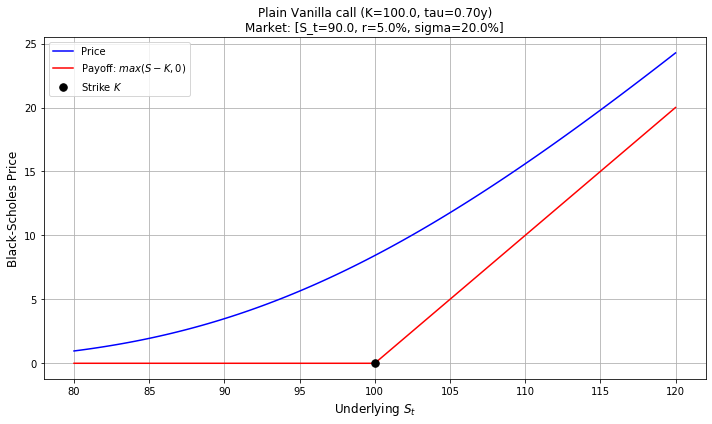

In [154]:
option_plotter.plot()

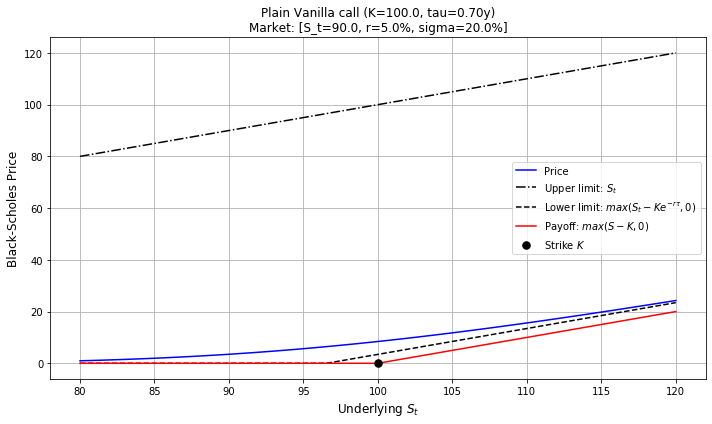

In [155]:
option_plotter.plot(plot_limits=True)

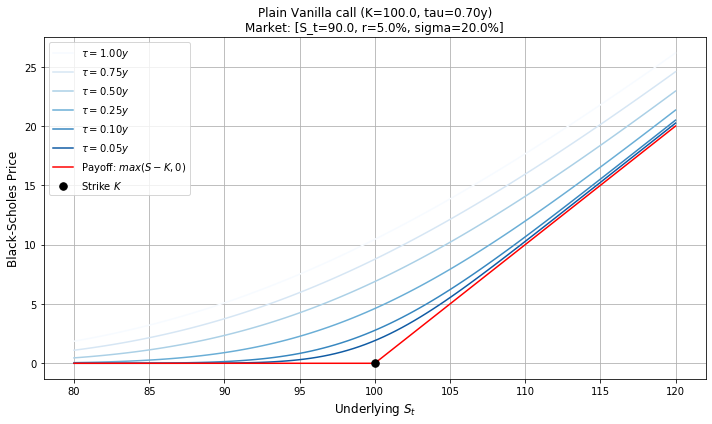

In [156]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

In [157]:
option_plotter = Plotter(Vanilla_Call, S=[80, 90, 100, 110, 120], tau=[0.01, 0.5, 1])

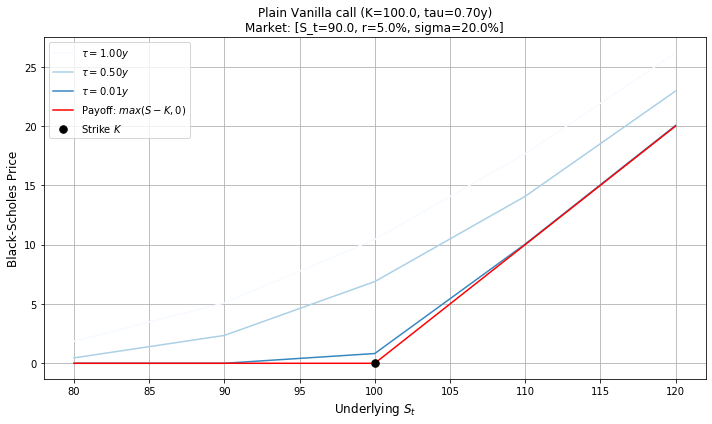

In [158]:
option_plotter.plot()

In [159]:
CON_Put = DigitalOption(market_env, option_type='put')
CON_Put

Initializing the EuropeanOption!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [160]:
option_plotter = Plotter(CON_Put)

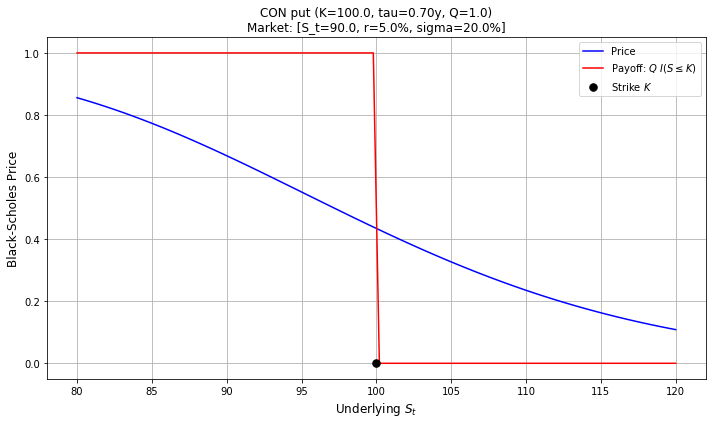

In [161]:
option_plotter.plot()

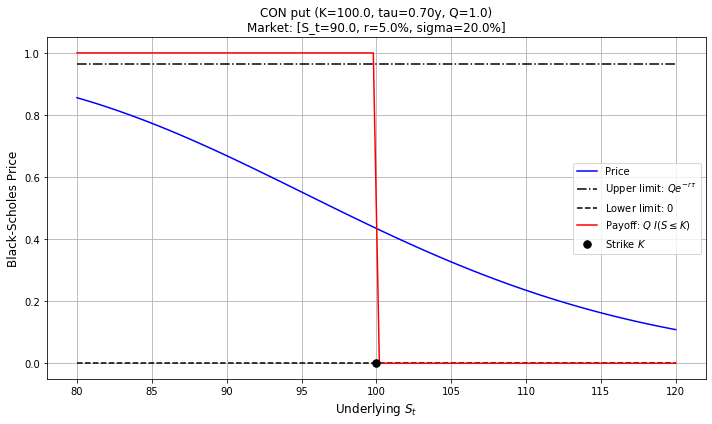

In [162]:
option_plotter.plot(plot_limits=True)

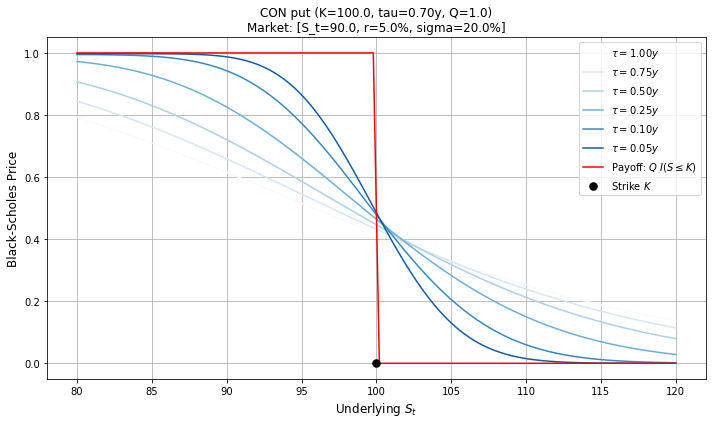

In [163]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

In [164]:
option_plotter = Plotter(CON_Put,  tau=[0.01, 0.5, 1])

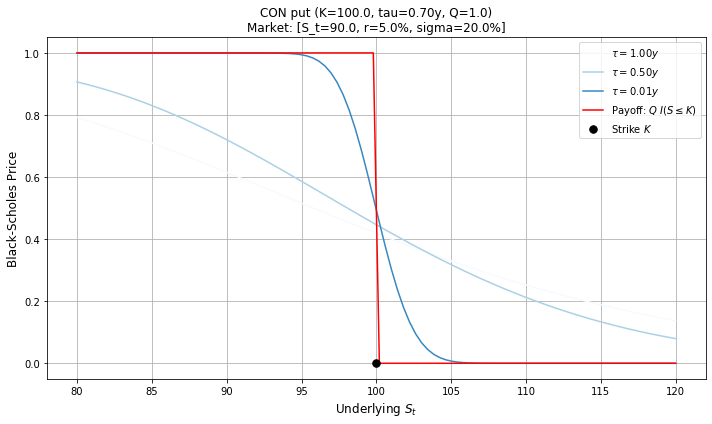

In [165]:
option_plotter.plot()

## _focus on:_ PnL

In [166]:
class EuropeanOption:
    """
    EuropeanOption abstract class: an interface setting the template for any option with european-style exercise.
    This class is not meant to be instantiated.
    
    Attributes:
    -----------
        type (str):               type of the option. Can be either 'call' or 'put';
        S_t (float):              'S' attribute of mkt_env.
        K (float):                strike price;
        t (str; dt.datetime):     't' attribute of mkt_env.
        T (str; dt.datetime):     expiration date. Can be either a "dd-mm-YYYY" String or a pd.datetime() object
        tau (float):              time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                'r' attribute of mkt_env.
        sigma (float):            'sigma' attribute of mkt_env.
    
    Template Methods:
    --------   
    
        getters for all common attributes
        
        setters for common attributes, not belonging to mkt_env
        
        payoff: float
            Template method for payoff. Raises NotImplementedError if called.

        price_upper_limit: float 
            Template method for upper limit. Raises NotImplementedError if called.

        price_lower_limit: float 
            Template method for lower limit. Raises NotImplementedError if called.
            
        price: float
            Template method for price. Raises NotImplementedError if called.

    """

    def __init__(self, mkt_env, option_type='call', K=100.0, T="31-12-2020"):
        
        print("Initializing the EuropeanOption!")

        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
        
        self.__type  = option_type
        self.__S     = mkt_env.get_S()
        self.__K     = K
        self.__t     = mkt_env.get_t()
        self.__T     = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        self.__tau   = self.__time_to_maturity()
        self.__r     = mkt_env.get_r()
        self.__sigma = mkt_env.get_sigma()
        
        # empty initial price of the option
        self.__initial_price = None
               
        # empty informations dictionary
        self.__docstring_dict = {}        
        
    # string representation method template
    def __repr__(self):
        raise NotImplementedError()
    
    # getters
    def get_type(self):
        return self.__type

    def get_S(self):
        return self.__S
    
    def get_sigma(self):
        return self.__sigma
    
    def get_K(self):
        return self.__K
    
    def get_t(self):
        return self.__t

    def get_T(self):
        return self.__T

    def get_tau(self):
        return self.__tau

    def get_r(self):
        return self.__r
    
    def get_sigma(self):
        return self.__sigma
    
    def get_initial_price(self):
        return NotImplementedError()
    
    # doctring getter template
    def get_docstring(self, label):
        raise NotImplementedError()

    # setters
    def set_type(self, option_type):
        self.__type = option_type
        
        # option type check
        if option_type not in ['call', 'put']:
            raise NotImplementedError("Option Type: '{}' does not exist!".format(option_type))
            
    def set_K(self, K):
        self.__K = K
    
    def set_T(self, T):
        self.__T = dt.datetime.strptime(T, "%d-%m-%Y") if isinstance(T, str) else T
        # update time to maturity, given changed T, to keep internal consistency
        self.__update_tau() 
    
    def set_tau(self, tau):
        self.__tau = tau
        # update expiration date, given changed tau, to keep internal consistency
        self.__update_T()
        
    def __update_T(self):
        self.__T = self.__t + dt.timedelta(days=math.ceil(self.__tau*365))

    # time to maturity method (private)
    def __time_to_maturity(self):
        return (self.__T - self.__t).days / 365.0
    
    # payoff template
    def payoff(self):
        raise NotImplementedError()     
        
    # upper price limit template
    def price_upper_limit(self):
        raise NotImplementedError()     

    # lower price limit template
    def price_lower_limit(self):
        raise NotImplementedError()     
        
    # price template
    def price(self):
        raise NotImplementedError()
        
    # profit and loss calculation calculation - with optional *args and **kwargs parameters
    def PnL(self, *args, **kwargs):
        """
        Can be called as:
            - PnL(): uses .get_S() and .get_tau()
            - PnL(100.0): S == 100.0
            - PnL(100.0, 0.1): S == 100.0 and tau == 0.1
            - PnL(S=100.0, tau=0.1)
            - PnL([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - PnL(S=[100.0, ..., 120.0], tau=0.1)
        """
        
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
        
        # if tau==0, this is the P&L at option's expiration, that is the PnL if the option is kept until maturity
        if tau == 0.0:
            # P&L = payoff - initial price
            return self.payoff(S) - self.get_initial_price()
        
        # if tau > 0, this is the P&L as if the option position is closed before maturity, when the time-to-maturity is tau
        else:
            # P&L = current price - initial price
            return self.price(S, tau) - self.get_initial_price()

In [167]:
class PlainVanillaOption(EuropeanOption):
    """
    PlainVanillaOption class implementing payoff and pricing of plain-vanilla call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
    
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: PlainVanillaOption(mkt_env) is equivalent to 
                   PlainVanillaOption(mkt_env, option_type='call', K=100.0, T="31-12-2020")

        - general: PlainVanillaOption(mkt_env, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """
    
    # initializer with optional *args and **kwargs parameters
    def __init__(self, *args, **kwargs):  
        
        # calling the EuropeanOption constructor
        super(PlainVanillaOption, self).__init__(*args, **kwargs)
        
        # info strings
        self.__info = r"Plain Vanilla {} (K={:.1f}, tau={:.2f}y)".format(self.get_type(), self.get_K(), self.get_tau())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100)
        
        # initial price of the option
        self.__initial_price = self.price()
        
        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $S_t$",
                'payoff':            r"Payoff: $max(S-K, 0)$",
                'price_lower_limit': r"Lower limit: $max(S_t - K e^{-r \tau}, 0)$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $K e^{-r \tau}$",
                'payoff':            r"Payoff: $max(K-S, 0)$",
                'price_lower_limit': r"Lower limit: $max(K e^{-r \tau} - S_t, 0)$"}
        }
                
    def __repr__(self):
        return r"PlainVanillaOption('{}', S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_initial_price(self):
        return self.__initial_price

    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called as:
            - payoff(): uses .get_S() 
            - payoff(100.0): S == 100.0
            - payoff(S=100.0)
            - payoff([100.0, ..., 120.0]): S == [100.0, ..., 120.0] 
            - payoff(S=[100.0, ..., 120.0])
        """
        
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
                
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)
    
    def __call_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([max(0.0, s - self.get_K()) for s in S])
        else:
            return max(0.0, S - self.get_K())

    def __put_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([max(0.0, self.get_K() - s) for s in S])
        else:
            return max(0.0, self.get_K() - S)
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_upper_limit(): uses .get_S() and .get_tau()
            - price_upper_limit(100.0): S == 100.0
            - price_upper_limit(100.0, 0.1): S == 100.0 and tau == 0.1
            - price_upper_limit(S=100.0, tau=0.1)
            - price_upper_limit([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price_upper_limit(S=[100.0, ..., 120.0], tau=0.1)
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
                        
        # call case
        if self.get_type() == 'call':
            return S
        # put case
        else:
            return self.__put_price_upper_limit(S, tau)
    
    def __put_price_upper_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.repeat(self.get_K()*np.exp(-self.get_r() * tau), repeats=len(S)) 
        else:
            return self.get_K()*np.exp(-self.get_r() * tau)

    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_lower_limit(): uses .get_S() and .get_tau()
            - price_lower_limit(100.0): S == 100.0
            - price_lower_limit(100.0, 0.1): S == 100.0 and tau == 0.1
            - price_lower_limit(S=100.0, tau=0.1)
            - price_lower_limit([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price_lower_limit(S=[100.0, ..., 120.0], tau=0.1)
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
                                       
        # call case
        if self.get_type() == 'call':
            return self.__call_price_lower_limit(S, tau)
        # put case
        else:
            return self.__put_price_lower_limit(S, tau)

    def __call_price_lower_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.array([max(s - self.get_K()*np.exp(-self.get_r() * tau), 0.0) for s in S])
        else:
            return max(S - self.get_K()*np.exp(-self.get_r() * tau), 0.0)
                                       
    def __put_price_lower_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.array([max(self.get_K()*np.exp(-self.get_r() * tau) - s, 0.0) for s in S])
        else:
            return max(self.get_K()*np.exp(-self.get_r() * tau) - S, 0.0)
                                       
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called as:
            - price(): uses .get_S() and .get_tau()
            - price(100.0): S == 100.0
            - price(100.0, 0.1): S == 100.0 and tau == 0.1
            - price(S=100.0, tau=0.1)
            - price([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price(S=[100.0, ..., 120.0], tau=0.1)
        """
                       
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
               
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
        
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: Call + Ke^{-r*tau} = Put + S"""
        return self.__call_price(S, tau) + self.get_K() * np.exp(- self.get_r() * tau) - S     

In [168]:
class DigitalOption(EuropeanOption):
    """
    DigitalOption class implementing payoff and pricing of digital call and put options.
    Put price is calculated using put-call parity
    
    Attributes:
    -----------
        mkt_env (MarketEnvironment): Instance of MarketEnvironment class
        Q (float):                   cash amount
        type (str):                  From 'type' attribute of EuropeanOption base class.
        S_t (float):                 'S' attribute of mkt_env.
        K (float):                   From 'K' attribute of EuropeanOption base class.
        t (str; dt.datetime):        't' attribute of mkt_env.
        T (str; dt.datetime):        From 'T' attribute of EuropeanOption base class.
        tau (float):                 time to maturity in years, computed as tau=T-t by time_to_maturity() method
        r (float):                   'r' attribute of mkt_env.
        sigma (float):               'sigma' attribute of mkt_env.
    
    Public Methods:
    --------   
    
        payoff: float
            Computes the payoff of the option and returns it

        price_upper_limit: float 
            Returns the upper limit for a vanilla option price.

        price_lower_limit: float 
            Returns the lower limit for a vanilla option price.
            
        price: float
            Computes the exact price of the option and returns it, using call_price() or put_price()

    Usage: 
    --------   
        - default: DigitalOption(mkt_env) is equivalent to 
                   DigitalOption(mkt_env, cash_amount=1.0, option_type='call', K=100.0, T="31-12-2020")

        - general: DigitalOption(mkt_env, cash_amount=Float, option_type='call' or 'put' String, K=Float, T="DD-MM-YYYY" String)

    where: mkt_env is a MarketEnvironment instance.
    """

    # initializer with optional *args and **kwargs parameters and default cash_amount
    # default keyword arguments (like cash_amount here) must go after args list argument in function def
    def __init__(self, *args, cash_amount=1.0, **kwargs):  
        
        # calling the EuropeanOption constructor
        super(DigitalOption, self).__init__(*args, **kwargs)
        
        # amount of cash in case of payment
        self.__Q = cash_amount    
        
        # info strings
        self.__info = r"CON {} (K={:.1f}, tau={:.2f}y, Q={:.1f})".format(self.get_type(), self.get_K(), self.get_tau(), self.get_Q())
        self.__mkt_info = r"[S_t={:.1f}, r={:.1f}%, sigma={:.1f}%]".format(self.get_S(), self.get_r()*100, self.get_sigma()*100)
        
        # initial price of the option
        self.__initial_price = self.price()

        # informations dictionary
        self.__docstring_dict = {
            'call':{
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S > K)$",
                'price_lower_limit': r"Lower limit: $0$"
            },
            'put': {
                'price_upper_limit': r"Upper limit: $Q e^{-r \tau}$",
                'payoff':            r"Payoff: $Q$ $I(S \leq K)$",
                'price_lower_limit': r"Lower limit: $0$"}
        }        
                
    def __repr__(self):
        return r"DigitalOption('{}', cash={:.1f}, S_t={:.1f}, K={:.1f}, t={}, T={}, tau={:.2f}y, r={:.1f}%, sigma={:.1f}%)".\
                format(self.get_type(), self.get_Q(), self.get_S(), self.get_K(), self.get_t().strftime("%d-%m-%Y"), 
                       self.get_T().strftime("%d-%m-%Y"), self.get_tau(), self.get_r()*100, self.get_sigma()*100)
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_Q(self):
        return self.__Q
    
    def get_initial_price(self):
        return self.__initial_price
    
    # docstring getter
    def get_docstring(self, label):
        return self.__docstring_dict[self.get_type()][label] 
    
    # setters
    def set_Q(self, cash_amount):
        self.__Q = cash_amount
    
    # payoff calculation - with optional *args and **kwargs parameters
    def payoff(self, *args, **kwargs):
        """
        Can be called as:
            - payoff(): uses .get_S() 
            - payoff(100.0): S == 100.0
            - payoff(S=100.0)
            - payoff([100.0, ..., 120.0]): S == [100.0, ..., 120.0] 
            - payoff(S=[100.0, ..., 120.0])
        """
        
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        
        # call case
        if self.get_type() == 'call':
            return self.__call_payoff(S)
        # put case
        else:
            return self.__put_payoff(S)

    def __call_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([self.get_Q() * int(s > self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S > self.get_K())

    def __put_payoff(self, S):
        if isinstance(S, Iterable):
            return np.array([self.get_Q() * int(s <= self.get_K()) for s in S])
        else:
            return self.get_Q() * int(S <= self.get_K())
        
    # upper price limit - with optional *args and **kwargs parameters
    def price_upper_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_upper_limit(): uses .get_S() and .get_tau()
            - price_upper_limit(100.0): S == 100.0
            - price_upper_limit(100.0, 0.1): S == 100.0 and tau == 0.1
            - price_upper_limit(S=100.0, tau=0.1)
            - price_upper_limit([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price_upper_limit(S=[100.0, ..., 120.0], tau=0.1)
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
            
        # the same for call and put
        return self.__price_upper_limit(S, tau)
 
    def __price_upper_limit(self, S, tau):
        if isinstance(S, Iterable):
            return np.repeat(self.get_Q()*np.exp(-self.get_r() * tau), repeats=len(S))
        else:
            return self.get_Q()*np.exp(-self.get_r() * tau)
                                       
    # lower price limit - with optional *args and **kwargs parameters
    def price_lower_limit(self, *args, **kwargs):
        """
        Can be called as:
            - price_lower_limit(): uses .get_S() 
            - price_lower_limit(100.0): S == 100.0
            - price_lower_limit(S=100.0)
            - price_lower_limit([100.0, ..., 120.0]): S == [100.0, ..., 120.0] 
            - price_lower_limit(S=[100.0, ..., 120.0])
        """

        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
            
        # call case
        if self.get_type() == 'call':
            return np.repeat(0.0, repeats=len(S)) if isinstance(S, Iterable) else 0.0
        # put case
        else:
            return np.repeat(0.0, repeats=len(S)) if isinstance(S, Iterable) else 0.0
        
    # price calculation - with optional *args and **kwargs parameters
    def price(self, *args, **kwargs):
        """
        Can be called as:
            - price(): uses .get_S() and .get_tau()
            - price(100.0): S == 100.0
            - price(100.0, 0.1): S == 100.0 and tau == 0.1
            - price(S=100.0, tau=0.1)
            - price([100.0, ..., 120.0], 0.1): S == [100.0, ..., 120.0] and tau == 0.1
            - price(S=[100.0, ..., 120.0], tau=0.1)
        """
                       
        S = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.get_S()
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.get_tau()
            
        # call case
        if self.get_type() == 'call':
            return np.array([self.__call_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__call_price(S, tau)
        # put case
        else:
            return np.array([self.__put_price(s, tau) for s in S]) if isinstance(S, Iterable) else self.__put_price(S, tau)
          
    def __call_price(self, S, tau):
                
        if S == 0: # this is to avoid log(0) issues
            return 0.0
        elif tau == 0.0: # this is to avoid 0/0 issues
            return self.__call_payoff(S)
        else:
            Q     = self.get_Q()
            K     = self.get_K()
            r     = self.get_r()
            sigma = self.get_sigma()

            d1 = (np.log(S/K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
            d2 = d1 - sigma * np.sqrt(tau)

            price = Q * np.exp(-r * tau) * stats.norm.cdf(d2, 0.0, 1.0)

            return price
    
    def __put_price(self, S, tau):
        """ Put price from Put-Call parity relation: CON_Call + CON_Put = Qe^{-r*tau}"""
        return self.get_Q() * np.exp(- self.get_r() * tau) - self.__call_price(S, tau)        

In [169]:
Vanilla_Call = PlainVanillaOption(market_env)
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [170]:
Vanilla_Call.price()

3.487402470943657

In [171]:
Vanilla_Call.payoff()

0.0

In [172]:
Vanilla_Call.PnL()

0.0

In [173]:
Vanilla_Call.PnL(tau=0)

-3.487402470943657

In [174]:
Vanilla_Call.get_K()

100.0

In [175]:
Vanilla_Call.PnL(S=110, tau=0)

6.512597529056343

`getattr` 

In [176]:
getattr(Vanilla_Call, 'price')()

3.487402470943657

In [177]:
str(getattr(Vanilla_Call, 'PnL'))

"<bound method EuropeanOption.PnL of PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)>"

In [178]:
getattr(Vanilla_Call, 'PnL')()

0.0

In [179]:
class Plotter():
    
    def __init__(self, FinancialInstrument, *args, **kwargs):

        # parse informations from FinancialInstrument
        self.fin_inst = FinancialInstrument
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market: " + self.fin_inst.get_mkt_info()

        # define x-axis 
        S_range = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.fin_inst.get_K()
        self.set_x_axis(S_range)

        # define multi-lines (different tau)
        multi_tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.fin_inst.get_tau()
        self.set_multi_tau(multi_tau)
        
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_tau(self):
        return self.__multi_tau

    def get_title(self):
        return self.__title_label
    
    # setters
    def set_x_axis(self, x):
        
        if isinstance(x, Iterable):
            self.__x_axis = x
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20
            
            self.__x_axis = np.linspace(x_min, x_max, 100)
    
    def set_multi_tau(self, tau):
        if isinstance(tau, Iterable) and len(tau) > 1:
            # sort and take the reversed array
            self.__multi_tau = np.sort(tau)[::-1]
        elif isinstance(tau, Iterable) and len(tau) == 1:
            self.__multi_tau = tau[0]
        else:
            self.__multi_tau = tau
                    
    def plot(self, *args, method_name='price', **kwargs):
        
        # parse optional parameters
        if len(args) > 0:
            self.set_x_axis(args[0])
        elif 'S' in kwargs:
            self.set_x_axis(kwargs['S'])
            
        if len(args) > 1:
            self.set_multi_tau(args[1])
        elif 'tau' in kwargs:
            self.set_multi_tau(kwargs['tau'])
            
        # get x-axis and, possibly, multi-tau
        x_axis = self.get_x_axis()
        tau = self.get_tau()
        
        if isinstance(tau, Iterable):
            self.__plot_multi_tau(x_axis, tau, method_name)
        else:
            plot_limits = args[2] if len(args) > 2 else kwargs['plot_limits'] if 'plot_limits' in kwargs else False
            self.__plot_single_tau(x_axis, tau, plot_limits, method_name)
            
    def __plot_multi_tau(self, S, multi_tau, method_name):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple times-to-maturity.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multi_tau))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different time to maturity tau
        for tau in multi_tau:

            ax.plot(S, getattr(self.fin_inst, method_name)(S, tau), '-', lw=1.5, label=r"$\tau={:.2f}y$".format(tau))

        # blue dot at original underlying level for reference, one dot for each different time to maturity tau
        for tau in multi_tau:
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, method_name)(S_t, tau), '.', ms=10, 
                    label=r"$\tau={:.2f}y$ at $S={:.1f}$".format(tau, S_t))
            
        # plot the red payoff line for different underlying values
        if method_name == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different times-to-maturity $\tau$", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(method_name), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
    
    def __plot_single_tau(self, S, tau, plot_limits, method_name):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed time-to-maturity. Possibly, it plots theoretical
        upper and lower bounds of the price.
        """

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        if tau > 0:
            ax.plot(S, getattr(self.fin_inst, method_name)(S, tau), 'b-', lw=1.5, label=method_name)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, method_name)(S_t, tau), 'b.', ms=15, 
                label=method_name + r" at $S={:.1f}$".format(S_t))
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, tau), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, tau), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        if method_name == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at time-to-maturity $\tau={:.2f}y$".format(tau), fontsize=12) 
        ax.set_ylabel('Black-Scholes {}'.format(method_name), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

In [180]:
market_env

MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

In [181]:
Vanilla_Call

PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [182]:
option_plotter = Plotter(Vanilla_Call)

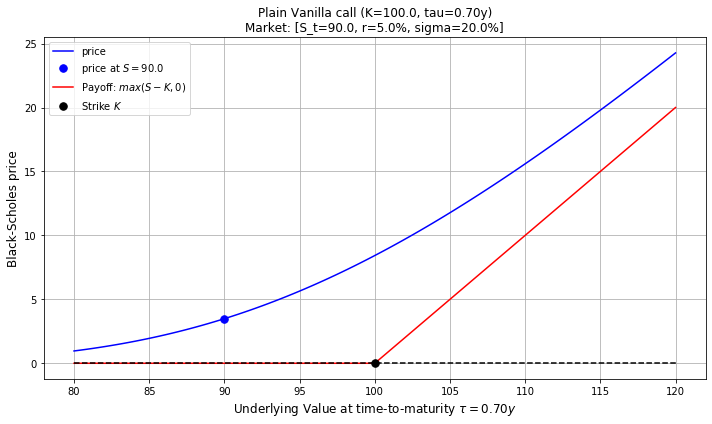

In [183]:
option_plotter.plot()

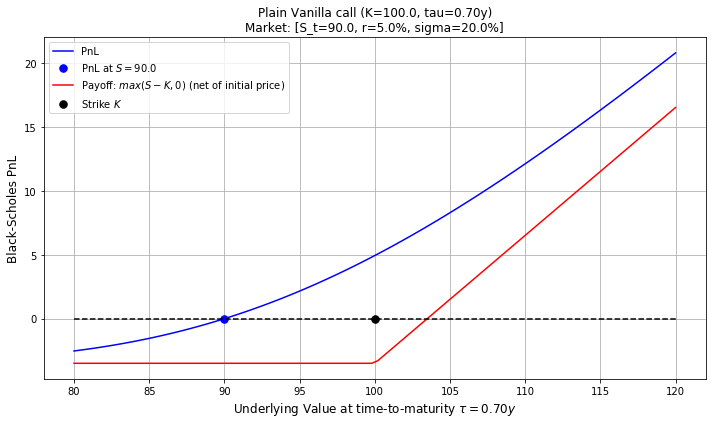

In [184]:
option_plotter.plot(method_name='PnL')

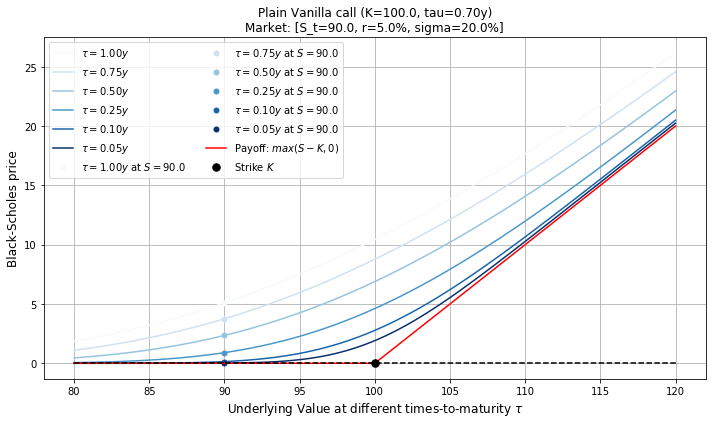

In [185]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

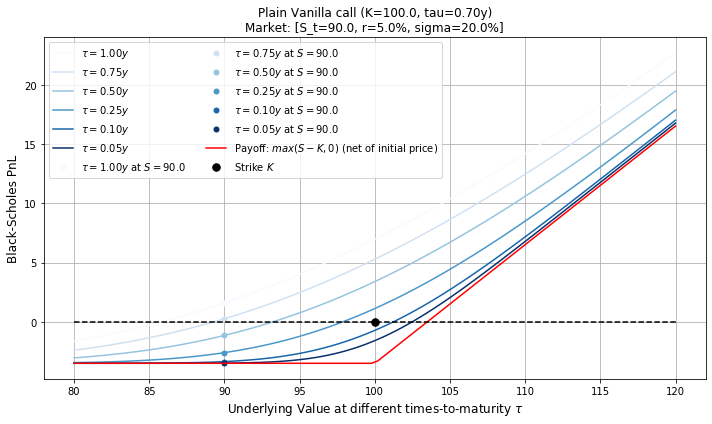

In [186]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0], method_name='PnL')

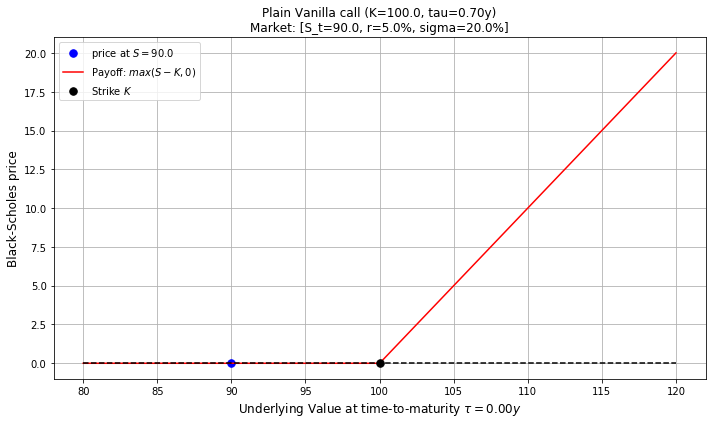

In [187]:
option_plotter.plot(tau=0.0)

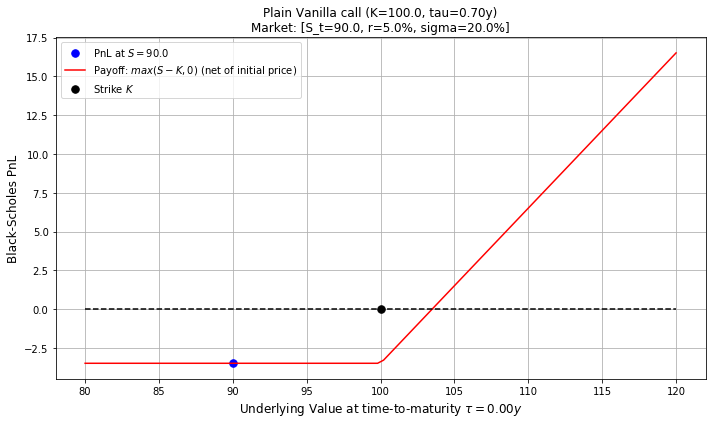

In [188]:
option_plotter.plot(tau=0.0, method_name='PnL')

In [189]:
CON_Call = DigitalOption(market_env)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [190]:
option_plotter = Plotter(CON_Call)

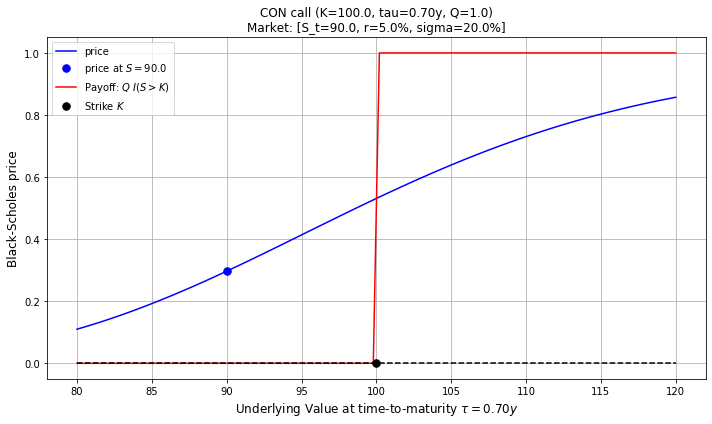

In [191]:
option_plotter.plot()

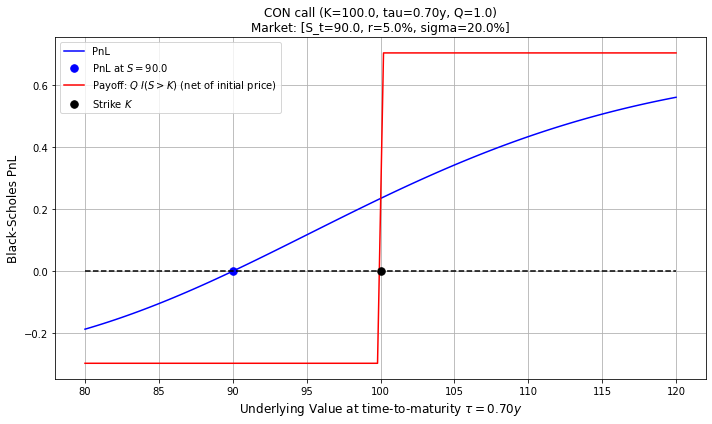

In [192]:
option_plotter.plot(method_name='PnL')

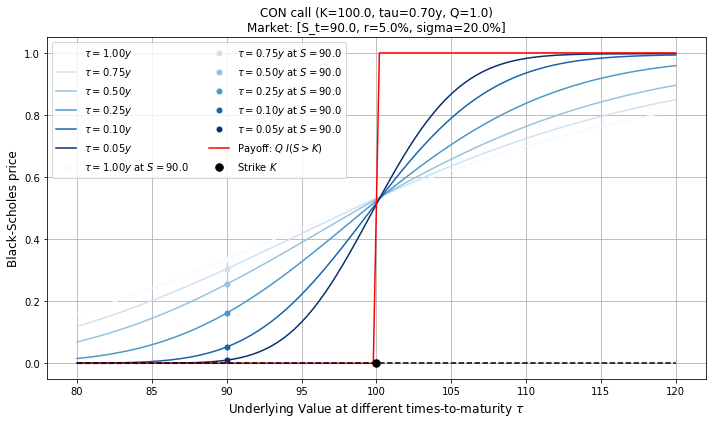

In [193]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0])

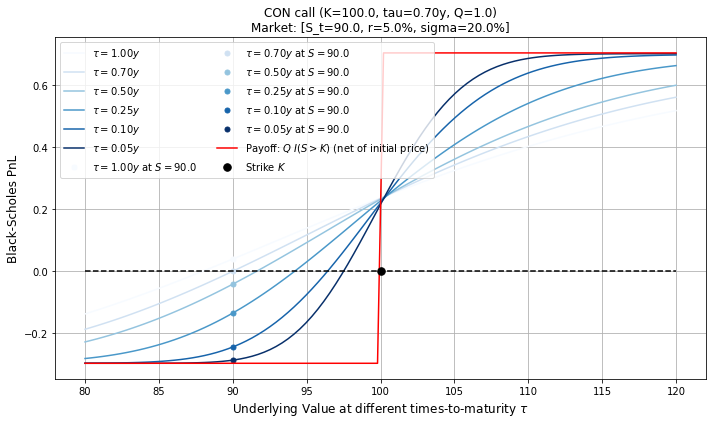

In [194]:
option_plotter.plot(tau=[0.05, 0.1, 0.25, 0.5, 0.7, 1.0], method_name='PnL')

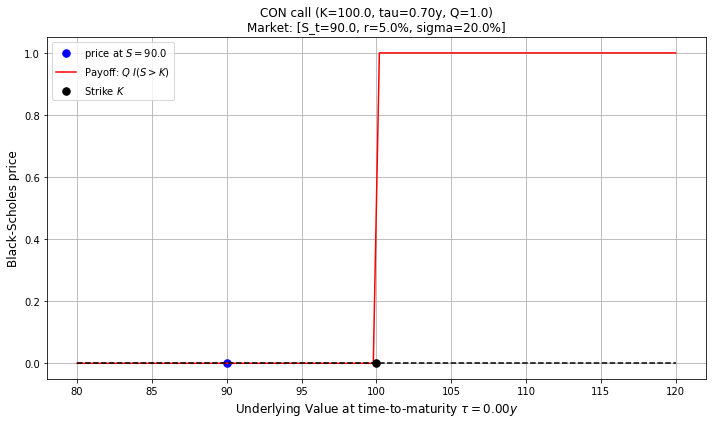

In [195]:
option_plotter.plot(tau=0.0)

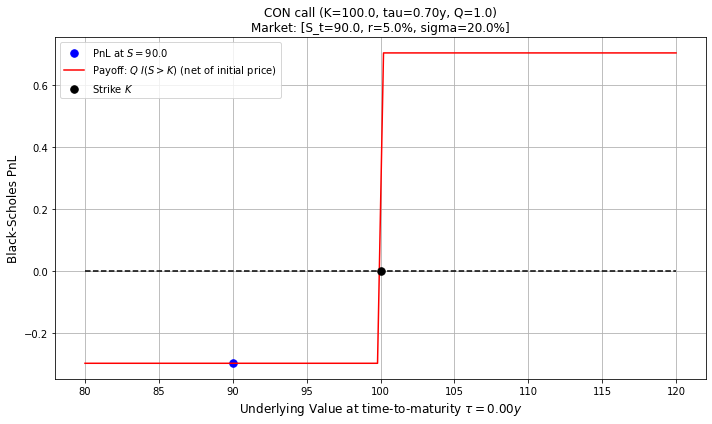

In [196]:
option_plotter.plot(tau=0.0, method_name='PnL')

# Composition application: a `Portfolio()` class

In [197]:
class Portfolio:
    
    def __init__(self, name=""):
        
        # initialize an empty portfolio
        self.__composition = []
        
        # initialize empty info strings
        self.__info = "{} Portfolio: \n".format(name)
        self.__mkt_info = None
        
        # initialize empty list of strikes, times-to-maturity and underlying value
        self.__K = []
        self.__tau = []
        self.__S = None
        
    def __repr__(self):
        return self.get_info()
    
    # getters
    def get_info(self):
        return self.__info
    
    def get_mkt_info(self):
        return self.__mkt_info
    
    def get_K(self):
        return self.__K
    
    def get_S(self):
        return self.__S

    def get_tau(self):
        return self.__tau
    
    def get_composition(self):
        return self.__composition
    
    # setters
    def set_S(self, S):
        self.__S = S
    
    # composition method
    def add_instrument(self, FinancialInstrument, position):
        
        self.__composition.append({"instrument": FinancialInstrument,
                                   "position":   position})
        
        # update portfolio attributes
        self.__update_info(FinancialInstrument, position)
        self.__update_K(FinancialInstrument)
        self.__update_tau(FinancialInstrument)
        if self.get_S() is None:
            self.set_S(FinancialInstrument.get_S())
    
    # private method to update the info
    def __update_info(self, fin_inst, pos):
        self.__info += fin_inst.get_info() + " (position: {})".format(pos) + "\n"
        if self.__mkt_info is None:
            self.__mkt_info = fin_inst.get_mkt_info()
            
    def __update_K(self, fin_inst):
        self.__K.append(fin_inst.get_K())

    def __update_tau(self, fin_inst):
        self.__tau.append(fin_inst.get_tau())
        
    def __check_tau_consistency(self, tau):
        if len(tau) != len(self.get_composition()):
            raise NotImplementedError("len(tau) == {} != {} number of instruments in portfolio".\
                                      format(len(tau), len(self.get_composition())))
        
    # portfolio "payoff", that is expiration value
    def payoff(self, S):
                
        if self.get_composition(): 

            instruments_payoff = np.array([instrument["instrument"].payoff(S) for instrument in self.get_composition()])
            
            positions = np.array([instrument["position"] for instrument in self.get_composition()])
            
            return positions.dot(instruments_payoff)
            
        else: # if portfolio is empty returns 0
            
            return 0.0  
        
    # portfolio value calculation
    def price(self, S, tau):
        
        if self.get_composition(): 
            
            if isinstance(tau, Iterable): # one tau per instrument
                self.__check_tau_consistency(tau)
                instruments_price = np.array([instrument["instrument"].price(S, tau) for tau, instrument in zip(tau, self.get_composition())])
            else: # same tau each instrument
                instruments_price = np.array([instrument["instrument"].price(S, tau) for instrument in self.get_composition()])

            positions = np.array([instrument["position"] for instrument in self.get_composition()])
            
            return positions.dot(instruments_price)
            
        else: # if portfolio is empty returns 0
            
            return 0.0    
        
    # portfolio P&L calculation
    def PnL(self, S, tau):
                
        if self.get_composition(): 
            
            if isinstance(tau, Iterable): # one tau per instrument
                self.__check_tau_consistency(tau)
                instruments_PnL = np.array([instrument["instrument"].PnL(S, tau) for tau, instrument in zip(tau, self.get_composition())])
            else: # same tau each instrument
                instruments_PnL = np.array([instrument["instrument"].PnL(S, tau) for instrument in self.get_composition()])

            positions = np.array([instrument["position"] for instrument in self.get_composition()])
            
            return positions.dot(instruments_PnL)
            
        else: # if portfolio is empty returns 0
            
            return 0.0        

In [198]:
Vanilla_Call = PlainVanillaOption(market_env)
Vanilla_Call

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [199]:
Vanilla_Put = PlainVanillaOption(market_env, option_type='put')
Vanilla_Put

Initializing the EuropeanOption!


PlainVanillaOption('put', S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [200]:
CON_Call = DigitalOption(market_env)
CON_Call

Initializing the EuropeanOption!


DigitalOption('call', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [201]:
CON_Put = DigitalOption(market_env, option_type='put')
CON_Put

Initializing the EuropeanOption!


DigitalOption('put', cash=1.0, S_t=90.0, K=100.0, t=19-04-2020, T=31-12-2020, tau=0.70y, r=5.0%, sigma=20.0%)

In [202]:
ptf = Portfolio()

In [203]:
ptf

 Portfolio: 

In [204]:
ptf.add_instrument(Vanilla_Call, 1)

In [205]:
ptf

 Portfolio: 
Plain Vanilla call (K=100.0, tau=0.70y) (position: 1)

In [206]:
S = Vanilla_Call.get_S()
tau = Vanilla_Call.get_tau()

In [207]:
ptf.price(S, tau)

3.487402470943657

In [208]:
Vanilla_Call.price()

3.487402470943657

In [209]:
ptf.add_instrument(Vanilla_Put, -5)

In [210]:
ptf

 Portfolio: 
Plain Vanilla call (K=100.0, tau=0.70y) (position: 1)
Plain Vanilla put (K=100.0, tau=0.70y) (position: -5)

In [211]:
ptf.payoff(S)

-50.0

In [212]:
1 * Vanilla_Call.payoff() - 5 * Vanilla_Put.payoff() 

-50.0

In [213]:
ptf.price(S, tau)

-46.71925046638197

In [214]:
1 * Vanilla_Call.price() - 5 * Vanilla_Put.price() 

-46.71925046638197

In [215]:
ptf.PnL(S, tau)

0.0

In [216]:
S_high = 2*Vanilla_Call.get_S()

In [217]:
ptf.PnL(S = S_high, tau=tau)

130.16321058561425

In [218]:
1 * Vanilla_Call.PnL(S = S_high) - 5 * Vanilla_Put.PnL(S = S_high) 

130.16321058561425

In [219]:
ptf.PnL(S = [S_high, S_high+1], tau=tau)

array([130.16321059, 131.16347883])

In [220]:
1 * Vanilla_Call.PnL(S = [S_high, S_high+1]) - 5 * Vanilla_Put.PnL(S = [S_high, S_high+1]) 

array([130.16321059, 131.16347883])

caso Calendar Spread

In [221]:
Vanilla_Call_short_term = PlainVanillaOption(market_env, K=100, T="31-05-2020")
Vanilla_Call_short_term

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-05-2020, tau=0.12y, r=5.0%, sigma=20.0%)

In [222]:
Vanilla_Call_long_term = PlainVanillaOption(market_env, K=100, T="31-10-2020")
Vanilla_Call_long_term

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=100.0, t=19-04-2020, T=31-10-2020, tau=0.53y, r=5.0%, sigma=20.0%)

In [223]:
ptf_calendar_spread = Portfolio()
ptf_calendar_spread.add_instrument(Vanilla_Call_short_term, -1)
ptf_calendar_spread.add_instrument(Vanilla_Call_long_term, 1)
ptf_calendar_spread

 Portfolio: 
Plain Vanilla call (K=100.0, tau=0.12y) (position: -1)
Plain Vanilla call (K=100.0, tau=0.53y) (position: 1)

In [224]:
tau_short = Vanilla_Call_short_term.get_tau()
tau_short

0.11506849315068493

In [225]:
tau_long = Vanilla_Call_long_term.get_tau()
tau_long

0.5342465753424658

In [226]:
ptf_calendar_spread.PnL(S=S, tau=[0.0, tau_long-tau_short])

-0.46318222858370817

In [227]:
s = np.linspace(80, 120, 100)
x = ptf_calendar_spread.PnL(S=s, tau=[0.0, tau_long-tau_short])

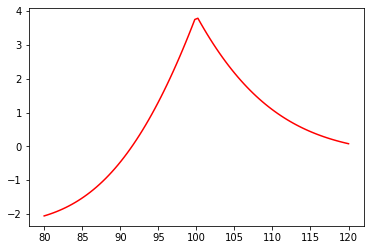

In [228]:
plt.plot(s, x, 'r-')

In [229]:
ptf_calendar_spread.get_K()

[100, 100]

In [230]:
ptf_calendar_spread.get_tau()

[0.11506849315068493, 0.5342465753424658]

In [231]:
ptf_calendar_spread.get_S()

90.0

In [232]:
class Plotter:
    """
    Interface Plotter class
    """
    
    def __init__(self, FinancialObject, *args, **kwargs):
        
        # parse informations from FinancialObject
        self.fin_inst = FinancialObject
        self.__title_label = self.fin_inst.get_info() + "\n" + "Market: " + self.fin_inst.get_mkt_info()
        
        # define empty x-axis object 
        self.__x_axis = None

    # getters
    def get_x_axis(self):
        raise NotImplementedError()
    
    # (differently specified according to the different kind of FinancialObject to plot)
    def get_tau(self):
        raise NotImplementedError() 

    def get_title(self):
        return self.__title_label
            
    # setter template for the x-axis (differently specified according to the different kind of FinancialObject to plot)
    def set_x_axis(self, x):
        raise NotImplementedError()
     
    # template plot method
    def plot(self):
        raise NotImplementedError()

class PortfolioPlotter(Plotter):
    """
    Plotter class for Portfolio
    """
    
    def __init__(self, Portfolio, *args, **kwargs):
        super(PortfolioPlotter, self).__init__(Portfolio)
 
        # define x-axis 
        S_range = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else None
        self.set_x_axis(S_range)

        # get times-to-maturity of each instrument in portfolio
        tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.fin_inst.get_tau()
        self.set_tau(tau)
        
    # getters
    def get_x_axis(self):
        return self.__x_axis
            
    def get_tau(self):
        return self.__tau
        
    # setters
    def set_x_axis(self, x):
        
        if x is None:
        
            strikes = self.fin_inst.get_K()

            x_min = max(min(strikes) - 20, 0.0)
            x_max = max(strikes) + 20

            self.__x_axis = np.linspace(x_min, x_max, 200)
            
        else:
            if isinstance(x, Iterable):
                self.__x_axis = x
            else:
                raise NotImplementedError("x-axis must be an Iterable")
                
    def set_tau(self, tau):
        if isinstance(tau, Iterable):
            self.__tau = tau
        else:
            self.__tau = [tau]
            
    def plot(self, *args, method_name='price', **kwargs):
        
        # parse optional parameters
        if len(args) > 0:
            self.set_x_axis(args[0])
        elif 'S' in kwargs:
            self.set_x_axis(kwargs['S'])
            
        if len(args) > 1:
            self.set_tau(args[1])
        elif 'tau' in kwargs:
            self.set_tau(kwargs['tau'])
            
        # get x-axis and, possibly, multi-tau
        x_axis = self.get_x_axis()
        tau = self.get_tau()
        
        self.__plot(x_axis, tau, method_name)

    def __plot(self, S, tau, method_name):
        """
        Plot Portfolio values against underlying value(s), possibly a different time-to-maturity for each instrument 
        in portfolio.
        """
        
        number_of_instruments = len(self.fin_inst.get_composition())
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.RdYlGn(np.linspace(0,1,number_of_instruments)))
        
        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values
        ax.plot(S, getattr(self.fin_inst, method_name)(S, tau), 'b-', lw=1.5, label=method_name)

        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, method_name)(S_t, tau), 'b.', ms=15, label=method_name + r" at $S={:.1f}$".format(S_t))
            
#        # plot the red payoff line for different underlying values
#        if method_name == 'PnL':
#            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=r"Portfolio payoff (net of initial price)")
#        else:
#            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=r"Portfolio payoff")

        # plot dashed red payoff lines for each instrument in the portfolio
        for tau_inst, inst in zip(tau, self.fin_inst.get_composition()):
            position = inst["position"]
            position_label = "+" if position > 0 else ""

            # plot the red payoff line for different underlying values
            if method_name == 'PnL':
                ax.plot(S, position * inst["instrument"].PnL(S, tau_inst), '--',  lw=1.5, 
                        label=method_name + " of " + position_label + str(position) + " " + inst["instrument"].get_info() + 
                              r" closed at $\tau={:.2f}y$".format(tau_inst))
            else:
                ax.plot(S, position * inst["instrument"].price(S, tau_inst), '--',  lw=1.5, 
                        label=method_name + " of " + position_label + str(position) + " " + inst["instrument"].get_info() +
                              r" closed at $\tau={:.2f}y$".format(tau_inst))
            
        
        # plot a dot to highlight the strike position and a reference zero line
        strikes = self.fin_inst.get_K()
        ax.plot(strikes, np.zeros_like(strikes), 'k.', ms=15, label="Strikes $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(method_name), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
        
class OptionPlotter(Plotter):
    """
    Plotter class for single options
    """
    
    def __init__(self, FinancialInstrument, *args, **kwargs):
        super(OptionPlotter, self).__init__(FinancialInstrument)

        # define x-axis 
        S_range = args[0] if len(args) > 0 else kwargs['S'] if 'S' in kwargs else self.fin_inst.get_K()
        self.set_x_axis(S_range)

        # define multi-lines (different tau)
        multi_tau = args[1] if len(args) > 1 else kwargs['tau'] if 'tau' in kwargs else self.fin_inst.get_tau()
        self.set_multi_tau(multi_tau)
        
    # getters
    def get_x_axis(self):
        return self.__x_axis

    def get_tau(self):
        return self.__multi_tau
    
    # setters
    def set_x_axis(self, x):
        
        if isinstance(x, Iterable):
            self.__x_axis = x
        else:
            x_min = max(x-20, 0.0)
            x_max = x+20
            
            self.__x_axis = np.linspace(x_min, x_max, 100)
    
    def set_multi_tau(self, tau):
        if isinstance(tau, Iterable) and len(tau) > 1:
            # sort and take the reversed array
            self.__multi_tau = np.sort(tau)[::-1]
        elif isinstance(tau, Iterable) and len(tau) == 1:
            self.__multi_tau = tau[0]
        else:
            self.__multi_tau = tau
                    
    def plot(self, *args, method_name='price', **kwargs):
        
        # parse optional parameters
        if len(args) > 0:
            self.set_x_axis(args[0])
        elif 'S' in kwargs:
            self.set_x_axis(kwargs['S'])
            
        if len(args) > 1:
            self.set_multi_tau(args[1])
        elif 'tau' in kwargs:
            self.set_multi_tau(kwargs['tau'])
            
        # get x-axis and, possibly, multi-tau
        x_axis = self.get_x_axis()
        tau = self.get_tau()
        
        if isinstance(tau, Iterable):
            self.__plot_multi_tau(x_axis, tau, method_name)
        else:
            plot_limits = args[2] if len(args) > 2 else kwargs['plot_limits'] if 'plot_limits' in kwargs else False
            self.__plot_single_tau(x_axis, tau, plot_limits, method_name)
            
    def __plot_multi_tau(self, S, multi_tau, method_name):
        """
        Plot FinancialInstrument values against underlying value(s), possibly at multiple times-to-maturity.
        """
        
        plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0,1,len(multi_tau))))

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))

        # plot the price for different underlying values, one line for each different time to maturity tau
        for tau in multi_tau:

            ax.plot(S, getattr(self.fin_inst, method_name)(S, tau), '-', lw=1.5, label=r"$\tau={:.2f}y$".format(tau))

        # blue dot at original underlying level for reference, one dot for each different time to maturity tau
        for tau in multi_tau:
            S_t = self.fin_inst.get_S()
            ax.plot(S_t, getattr(self.fin_inst, method_name)(S_t, tau), '.', ms=10, 
                    label=r"$\tau={:.2f}y$ at $S={:.1f}$".format(tau, S_t))
            
        # plot the red payoff line for different underlying values
        if method_name == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)
        
        # set axis labels 
        ax.set_xlabel(r"Underlying Value at different times-to-maturity $\tau$", fontsize=12)
        ax.set_ylabel('Black-Scholes {}'.format(method_name), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=2)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()
    
    def __plot_single_tau(self, S, tau, plot_limits, method_name):
        """
        Plot FinancialInstrument values against underlying value(s) at fixed time-to-maturity. Possibly, it plots theoretical
        upper and lower bounds of the price.
        """

        # define the figure
        fig, ax = plt.subplots(figsize=(10,6))
        
        # plot the price for different underlying values
        if tau > 0:
            ax.plot(S, getattr(self.fin_inst, method_name)(S, tau), 'b-', lw=1.5, label=method_name)
        
        # blue dot at original underlying level for reference
        S_t = self.fin_inst.get_S()
        ax.plot(S_t, getattr(self.fin_inst, method_name)(S_t, tau), 'b.', ms=15, 
                label=method_name + r" at $S={:.1f}$".format(S_t))
        
        if plot_limits==True:
            # plot the upper limit, the price and the lower limit for different underlying values
            ax.plot(S, self.fin_inst.price_upper_limit(S, tau), 'k-.', lw=1.5, label=self.fin_inst.get_docstring('price_upper_limit'))
            ax.plot(S, self.fin_inst.price_lower_limit(S, tau), 'k--', lw=1.5, label=self.fin_inst.get_docstring('price_lower_limit'))

        # plot the red payoff line for different underlying values
        if method_name == 'PnL':
            ax.plot(S, self.fin_inst.PnL(S, tau=0.0), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff') + r" (net of initial price)")
        else:
            ax.plot(S, self.fin_inst.payoff(S), 'r-',  lw=1.5, label=self.fin_inst.get_docstring('payoff'))

        # plot a dot to highlight the strike position and a reference zero line
        ax.plot(self.fin_inst.get_K(), 0, 'k.', ms=15, label="Strike $K$")
        ax.plot(S, np.zeros_like(S), 'k--', lw=1.5)

        # set axis labels 
        ax.set_xlabel(r"Underlying Value at time-to-maturity $\tau={:.2f}y$".format(tau), fontsize=12) 
        ax.set_ylabel('Black-Scholes {}'.format(method_name), fontsize=12) 

        # set title
        ax.set_title(self.get_title(), fontsize=12) 

        # add the legend ('best' loc parameters places the legend in the best position automatically)
        ax.legend(loc='best', ncol=1)

        # add a gride to ease visualization
        plt.grid(True)

        # show the plot
        fig.tight_layout()
        plt.show()

In [233]:
market_env

MarketEnvironment(t=19-04-2020, r=5.0%, S_t=90.0, sigma=20.0%)

In [234]:
Vanilla_Call_short_term = PlainVanillaOption(market_env, K=91, T="31-05-2020")
Vanilla_Call_short_term

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=91.0, t=19-04-2020, T=31-05-2020, tau=0.12y, r=5.0%, sigma=20.0%)

In [235]:
opt_short_plt = OptionPlotter(Vanilla_Call_short_term)

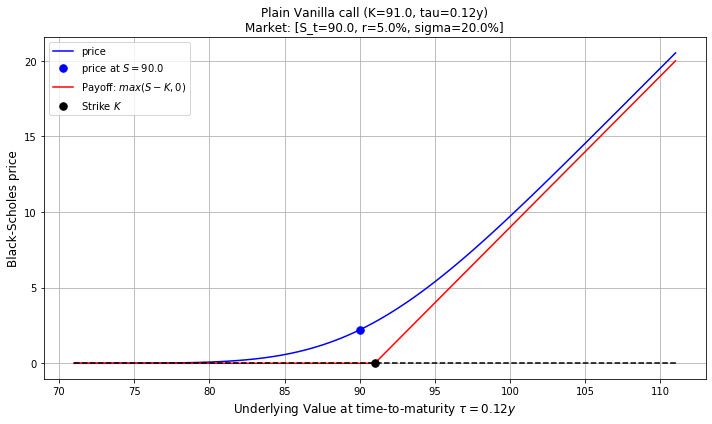

In [236]:
opt_short_plt.plot()

In [237]:
Vanilla_Call_long_term = PlainVanillaOption(market_env, K=91, T="30-06-2020")
Vanilla_Call_long_term

Initializing the EuropeanOption!


PlainVanillaOption('call', S_t=90.0, K=91.0, t=19-04-2020, T=30-06-2020, tau=0.20y, r=5.0%, sigma=20.0%)

In [238]:
opt_long_plt = OptionPlotter(Vanilla_Call_long_term)

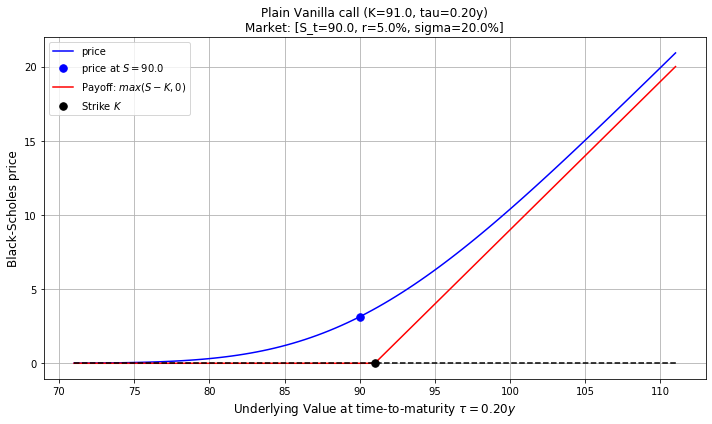

In [239]:
opt_long_plt.plot()

In [240]:
ptf = Portfolio(name="Calendar Spread")

In [241]:
ptf.add_instrument(Vanilla_Call_short_term, -1)
ptf.add_instrument(Vanilla_Call_long_term, 1)
ptf

Calendar Spread Portfolio: 
Plain Vanilla call (K=91.0, tau=0.12y) (position: -1)
Plain Vanilla call (K=91.0, tau=0.20y) (position: 1)

In [242]:
ptf_plt = PortfolioPlotter(ptf)

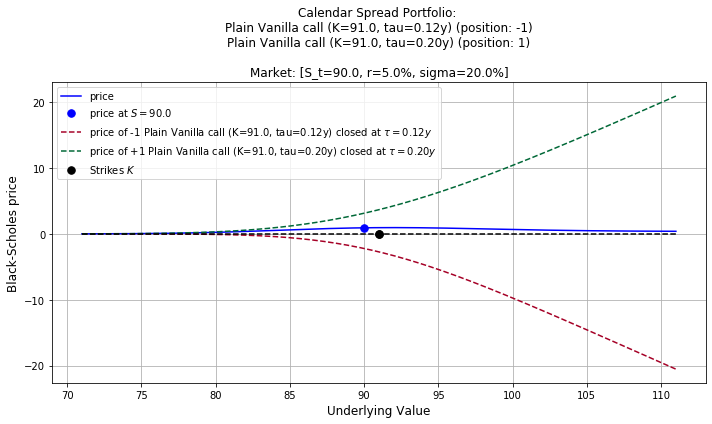

In [243]:
ptf_plt.plot()

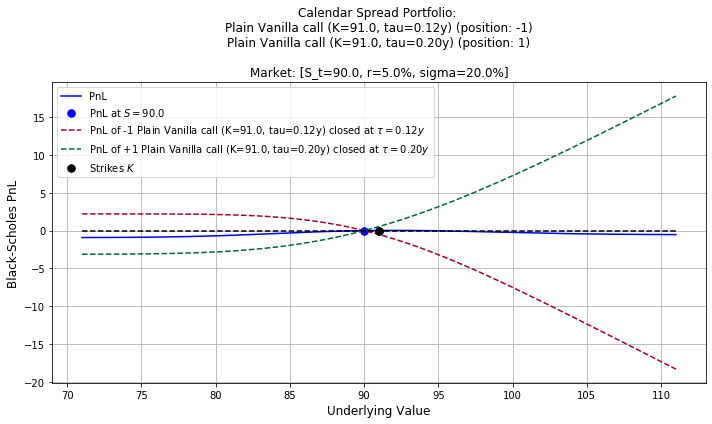

In [244]:
ptf_plt.plot(method_name='PnL')

In [245]:
tau_short = Vanilla_Call_short_term.get_tau()
tau_short

0.11506849315068493

In [246]:
tau_long = Vanilla_Call_long_term.get_tau()
tau_long

0.19726027397260273

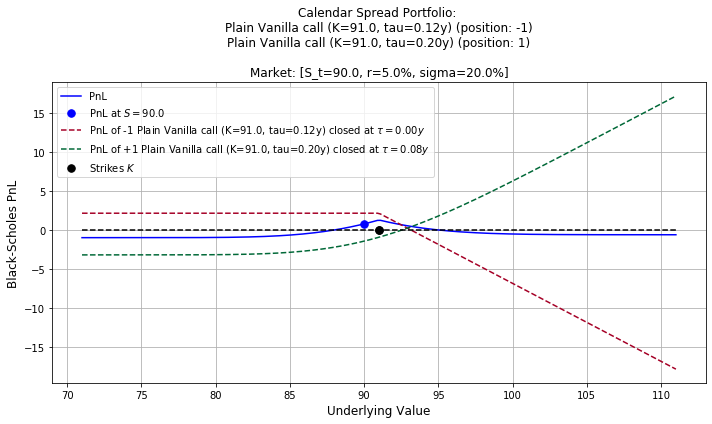

In [247]:
ptf_plt.plot(tau=[0.0, tau_long-tau_short], method_name='PnL')

In [248]:
ptf.PnL(S=400, tau=[0.0, tau_long-tau_short])

-0.5534661566454133